# Possible to-do's:

1. Aligned sequence analysis:
    - Fetch full protein sequences
    - Align
    - Check the numbering of SNPs (with or without the signal peptide?)
    - Assign SNPs to the meta-sequence
    - Assign the structural segments to the meta-sequence
    - Profit...

# GonmAD analysis

In [1]:
from pathlib import Path
import os
import pandas

In [2]:
from matplotlib import pyplot
import matplotlib
%matplotlib inline
matplotlib.style.use("ggplot")
matplotlib.rcParams["figure.figsize"] = (10, 10)

In [3]:
_folder_path = Path() / "Raw_data"
_raw_files = list(os.listdir(_folder_path))
print(_raw_files)

['gnomAD_v3.1.1_ENSG00000011677_2021_08_25_17_49_37_GABRA3.csv', 'gnomAD_v3.1.1_ENSG00000022355_2021_08_25_17_45_26_GABRA1.csv', 'gnomAD_v3.1.1_ENSG00000080644_2021_09_06_14_22_08_CHRNA3.csv', 'gnomAD_v3.1.1_ENSG00000094755_2021_08_25_17_53_59_GABRP.csv', 'gnomAD_v3.1.1_ENSG00000101204_2021_09_06_14_25_11_CHRNA4.csv', 'gnomAD_v3.1.1_ENSG00000101958_2021_08_26_22_07_30_GLRA2.csv', 'gnomAD_v3.1.1_ENSG00000102287_2021_08_25_17_51_00_GABRE.csv', 'gnomAD_v3.1.1_ENSG00000109158_2021_08_25_17_49_50_GABRA4.csv', 'gnomAD_v3.1.1_ENSG00000109738_2021_08_26_22_08_17_GLRB.csv', 'gnomAD_v3.1.1_ENSG00000111886_2021_08_25_17_54_36_GABRR2.csv', 'gnomAD_v3.1.1_ENSG00000113327_2021_08_25_17_52_13_GABRG2.csv', 'gnomAD_v3.1.1_ENSG00000120903_2021_08_26_22_10_13_CHRNA2.csv', 'gnomAD_v3.1.1_ENSG00000120903_2021_09_06_14_23_00_CHRNA2.csv', 'gnomAD_v3.1.1_ENSG00000138435_2021_08_26_22_09_48_CHRNA1.csv', 'gnomAD_v3.1.1_ENSG00000138435_2021_09_06_14_24_13_CHRNA1.csv', 'gnomAD_v3.1.1_ENSG00000145451_2021_08_26_22

## Importing the files
We import the file as pandas DataFrame and add a column in which we track the gene of interest.

In [4]:
data = []
for file in _raw_files:
    data.append(pandas.read_csv(_folder_path / file))
    data[-1]["Gene"] = file.split(".")[-2].split("_")[-1]

In [38]:
data[0]

,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,HGVS Consequence,Protein Consequence,...,Hemizygote Count Ashkenazi Jewish,Allele Count African/African-American,Allele Number African/African-American,Homozygote Count African/African-American,Hemizygote Count African/African-American,Allele Count European (non-Finnish),Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene
0,X,152168157,NaN,G,A,gnomAD Genomes,NaN,PASS,c.*71C>T,NaN,...,0,0,30604,0,0,0,53112,0,0,GABRA3
1,X,152168161,rs1384790433,C,T,gnomAD Genomes,NaN,PASS,c.*67G>A,NaN,...,0,1,30550,0,0,2,53058,0,0,GABRA3
2,X,152168162,rs1386272230,G,A,gnomAD Genomes,NaN,PASS,c.*66C>T,NaN,...,0,0,30614,0,0,3,53127,0,2,GABRA3
3,X,152168165,rs1603193519,G,A,gnomAD Genomes,NaN,PASS,c.*63C>T,NaN,...,0,1,30665,0,0,0,53180,0,0,GABRA3
4,X,152168167,rs1453252241,T,C,gnomAD Genomes,NaN,PASS,c.*61A>G,NaN,...,0,1,30551,0,0,0,53035,0,0,GABRA3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,X,152364593,rs1462667747,A,G,gnomAD Genomes,NaN,PASS,c.-23T>C,NaN,...,0,2,30588,0,1,0,53123,0,0,GABRA3
341,X,152364614,rs200503915,T,G,gnomAD Genomes,NaN,PASS,c.-26-18A>C,NaN,...,0,1,30551,0,0,8,53051,0,4,GABRA3
342,X,152364618,rs1380023644,T,A,gnomAD Genomes,NaN,PASS,c.-26-22A>T,NaN,...,0,0,30462,0,0,1,52933,0,0,GABRA3
343,X,152364628,rs1219359555,G,A,gnomAD Genomes,NaN,PASS,c.-26-32C>T,NaN,...,0,1,30672,0,0,0,53088,0,0,GABRA3


In [6]:
print(*list(data[0].columns), sep="\n")

Chromosome
Position
rsIDs
Reference
Alternate
Source
Filters - exomes
Filters - genomes
HGVS Consequence
Protein Consequence
Transcript Consequence
VEP Annotation
ClinVar Clinical Significance
ClinVar Variation ID
Flags
Allele Count
Allele Number
Allele Frequency
Homozygote Count
Hemizygote Count
Allele Count Other
Allele Number Other
Homozygote Count Other
Hemizygote Count Other
Allele Count Latino/Admixed American
Allele Number Latino/Admixed American
Homozygote Count Latino/Admixed American
Hemizygote Count Latino/Admixed American
Allele Count European (Finnish)
Allele Number European (Finnish)
Homozygote Count European (Finnish)
Hemizygote Count European (Finnish)
Allele Count Amish
Allele Number Amish
Homozygote Count Amish
Hemizygote Count Amish
Allele Count East Asian
Allele Number East Asian
Homozygote Count East Asian
Hemizygote Count East Asian
Allele Count Middle Eastern
Allele Number Middle Eastern
Homozygote Count Middle Eastern
Hemizygote Count Middle Eastern
Allele Count

In [7]:
print(*[len(x.columns) for x in data], sep="\n")

61
61
62
61
62
62
61
61
62
61
61
62
62
62
62
62
61
61
62
61
62
61
61
61
61
61
61
62
61
61
61
61
61
61
62
61
61
62
62
62
62
62
62
62
62
62
62


Some columns are present only in a subset of files. We look at one of those below.

In [8]:
set(data[2].columns) - set(data[0].columns)

{'Transcript'}

In [9]:
data[2]["Transcript"]

0      ENST00000348639.7
1      ENST00000348639.7
2      ENST00000348639.7
3      ENST00000348639.7
4      ENST00000348639.7
             ...        
598    ENST00000326828.6
599    ENST00000326828.6
600    ENST00000326828.6
601    ENST00000326828.6
602    ENST00000326828.6
Name: Transcript, Length: 603, dtype: object

We will keep them, and introduce NaN
## Joining the datasets

In [39]:
dataset = pandas.concat(data, axis=0, join="outer", ignore_index=True)
print(dataset)

      Chromosome     Position         rsIDs Reference Alternate  \
0              X  152168157.0           NaN         G         A   
1              X  152168161.0  rs1384790433         C         T   
2              X  152168162.0  rs1386272230         G         A   
3              X  152168165.0  rs1603193519         G         A   
4              X  152168167.0  rs1453252241         T         C   
...          ...          ...           ...       ...       ...   
28733          2  232545764.0  rs1329683219         A         G   
28734          2  232545766.0   rs377400953         T         A   
28735          2  232545769.0   rs962602943         G         T   
28736          2  232545774.0   rs970615017         A         G   
28737          2  232545783.0   rs980712487         G         A   

               Source  Filters - exomes Filters - genomes HGVS Consequence  \
0      gnomAD Genomes               NaN              PASS         c.*71C>T   
1      gnomAD Genomes               NaN

## Exploring the total dataset
### Different polymorphism annotations
For a complete description of the effect annotations see [the ensembl description](https://www.ensembl.org/info/genome/variation/prediction/predicted_data.html).

In [11]:
dataset["VEP Annotation"].unique()

array(['3_prime_UTR_variant', 'stop_retained_variant', 'missense_variant',
       'synonymous_variant', 'splice_region_variant', 'intron_variant',
       'stop_gained', '5_prime_UTR_variant', 'splice_acceptor_variant',
       'splice_donor_variant', 'frameshift_variant', 'inframe_deletion',
       'inframe_insertion', 'start_lost', 'stop_lost',
       'protein_altering_variant', nan], dtype=object)

In [12]:
_VEPs = ["missense_variant",
         "stop_gained",
         "splice_acceptor_variant",
         "splice_donor_variant",
         "frameshift_variant",
         "inframe_deletion",
         "inframe_insertion",
         "start_lost",
         "stop_lost",
         "protein_altering_variant"]
print(*[sum(dataset["VEP Annotation"] == x) for x in _VEPs], sep="\n")

8518
299
93
126
451
141
41
36
11
2


In [40]:
dataset.shape

(28738, 62)

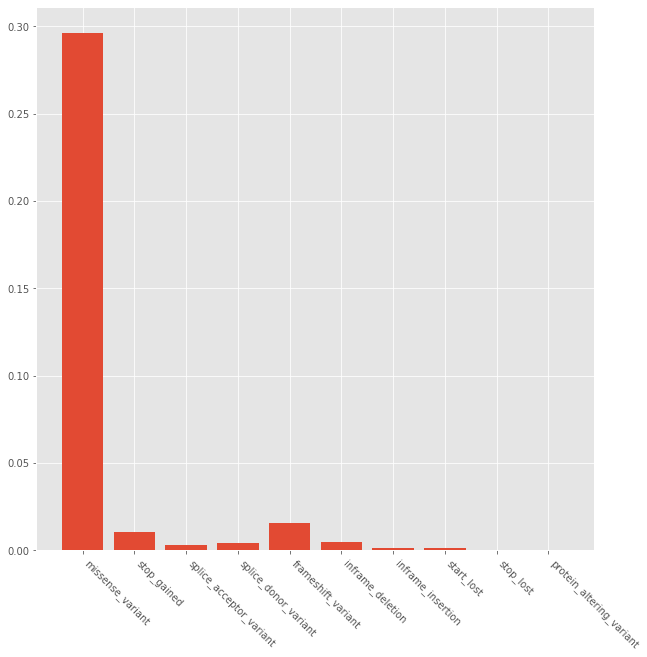

In [14]:
pyplot.bar(_VEPs, [sum(dataset["VEP Annotation"] == x)/dataset.shape[0]  for x in _VEPs])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.show()

## Filtering
For now we filter by including only variants present in at least 0.01 % of the population.

We also retain just the columns of interest. Let's see the distribution of the annotations now.

In [41]:
subdata = dataset[dataset["Allele Count"]/dataset["Allele Number"] > 0.0001]
subdata = subdata[subdata["VEP Annotation"].isin(_VEPs)]
subdata

,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,HGVS Consequence,Protein Consequence,...,Allele Count African/African-American,Allele Number African/African-American,Homozygote Count African/African-American,Hemizygote Count African/African-American,Allele Count European (non-Finnish),Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene,Transcript
330,X,152364513.0,rs746277466,T,A,gnomAD Genomes,NaN,PASS,p.Ile20Phe,p.Ile20Phe,...,13.0,30532.0,0.0,3.0,0.0,52998.0,0.0,0.0,GABRA3,NaN
335,X,152364537.0,rs61734348,T,A,gnomAD Genomes,NaN,PASS,p.Thr12Ser,p.Thr12Ser,...,128.0,30634.0,0.0,38.0,5.0,53119.0,0.0,2.0,GABRA3,NaN
400,5,161850837.0,rs113886269,C,A,gnomAD Genomes,NaN,PASS,p.Asp9Glu,p.Asp9Glu,...,113.0,41444.0,0.0,0.0,2.0,68030.0,0.0,0.0,GABRA1,NaN
492,5,161854168.0,rs143815396,C,T,gnomAD Genomes,NaN,PASS,p.Pro29Ser,p.Pro29Ser,...,19.0,41228.0,0.0,0.0,0.0,67638.0,0.0,0.0,GABRA1,NaN
880,5,161897276.0,rs139793542,C,T,gnomAD Genomes,NaN,PASS,p.Pro409Ser,p.Pro409Ser,...,16.0,41450.0,0.0,0.0,0.0,68036.0,0.0,0.0,GABRA1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28617,2,232544781.0,rs146674765,C,T,gnomAD Genomes,NaN,PASS,p.Pro420Leu,p.Pro420Leu,...,48.0,41416.0,0.0,0.0,1.0,68016.0,0.0,0.0,CHRNG,ENST00000651502.1
28646,2,232544900.0,rs138232636,A,G,gnomAD Genomes,NaN,PASS,p.Asn460Asp,p.Asn460Asp,...,5.0,41398.0,0.0,0.0,10.0,67994.0,0.0,0.0,CHRNG,ENST00000651502.1
28684,2,232545543.0,rs143800157,G,A,gnomAD Genomes,NaN,PASS,p.Gly461Arg,p.Gly461Arg,...,0.0,41448.0,0.0,0.0,6.0,68032.0,0.0,0.0,CHRNG,ENST00000651502.1
28691,2,232545583.0,rs16829216,G,A,gnomAD Genomes,NaN,PASS,p.Arg474His,p.Arg474His,...,4.0,41438.0,0.0,0.0,11.0,68024.0,0.0,0.0,CHRNG,ENST00000651502.1


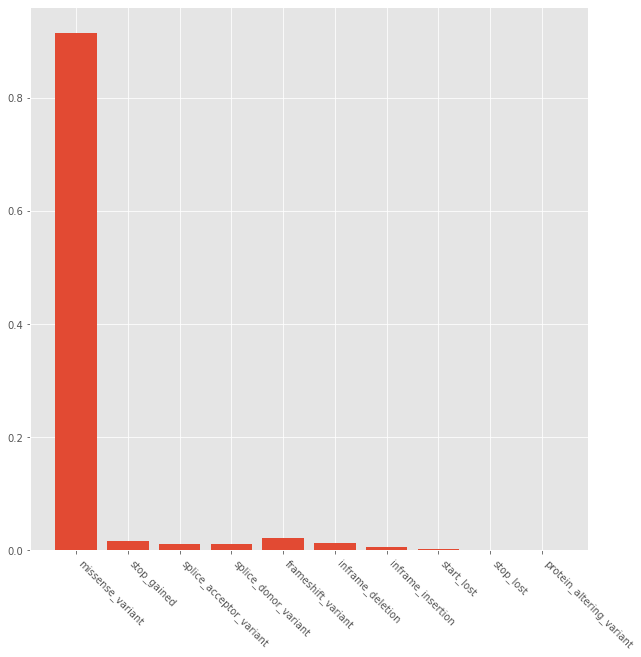

In [16]:
pyplot.bar(_VEPs, [sum(subdata["VEP Annotation"] == x)/subdata.shape[0]  for x in _VEPs])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.show()

## Distribution across the genes
First we just look at the number of different polymorphisms detected.

In [17]:
matplotlib.rcParams["figure.figsize"] = (30, 10)

In [18]:
_genes = subdata["Gene"].unique()
_values = pandas.DataFrame({"Gene": _genes, "Value": [sum(subdata["Gene"] == x)/subdata.shape[0]  for x in _genes]})
_values.sort_values(by="Value", ascending=False, inplace=True, ignore_index=True)

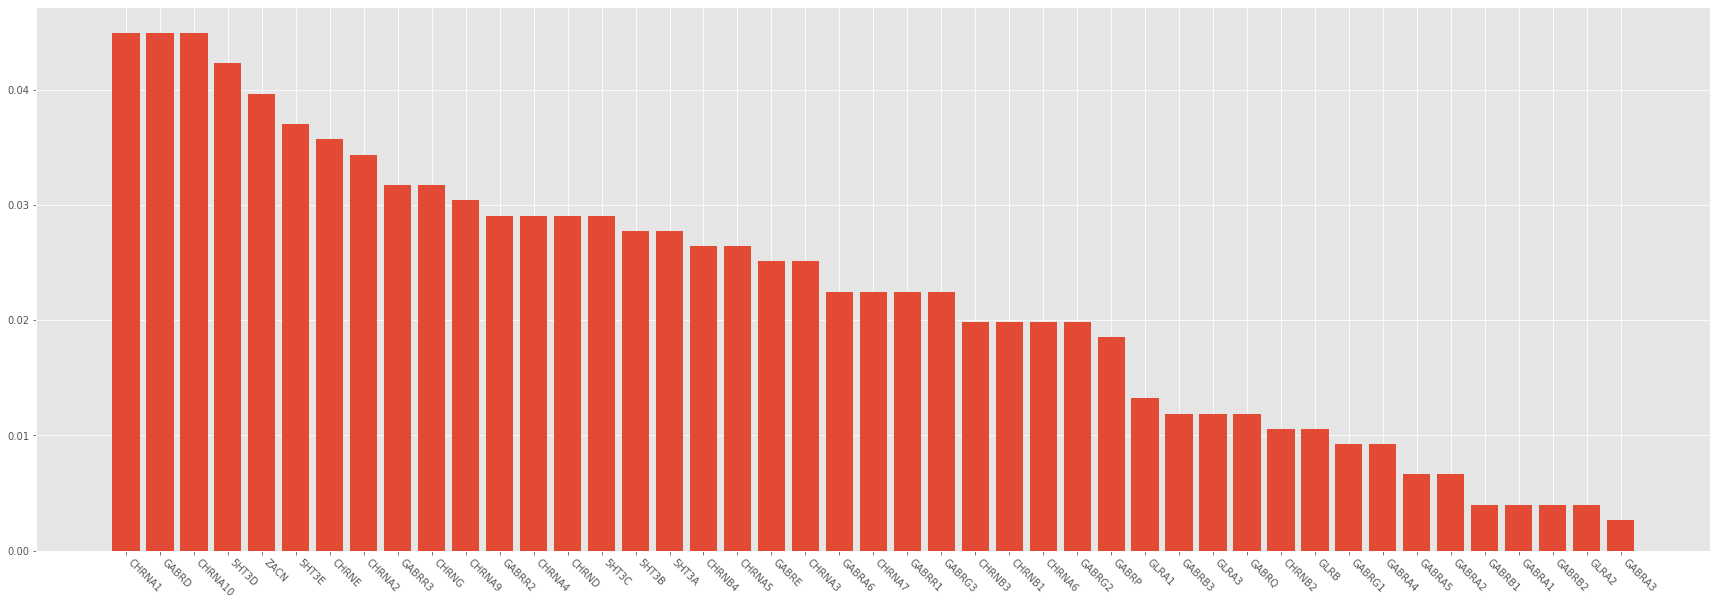

In [19]:
pyplot.bar(_values["Gene"], _values["Value"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.show()

Now we check the total number of detected alleles. Note that the sample sizes do not match. Acutally, let us first look at how much that deviates.

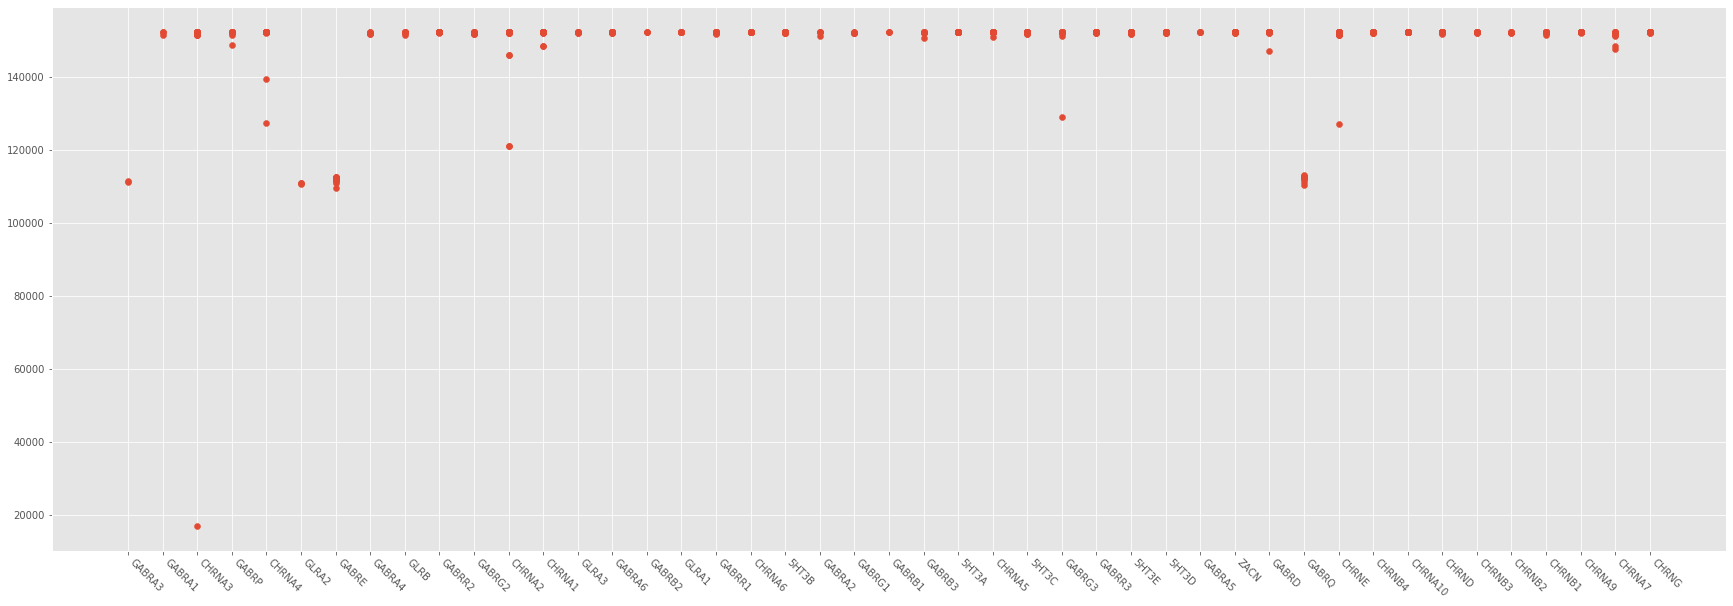

In [20]:
pyplot.scatter(subdata["Gene"], subdata["Allele Number"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.show()

In [42]:
_values["Allele Count"] = [sum(subdata["Allele Count"][subdata["Gene"] == x]) for x in _values["Gene"]]
_values.sort_values(by="Allele Count", ascending=False, inplace=True, ignore_index=True)

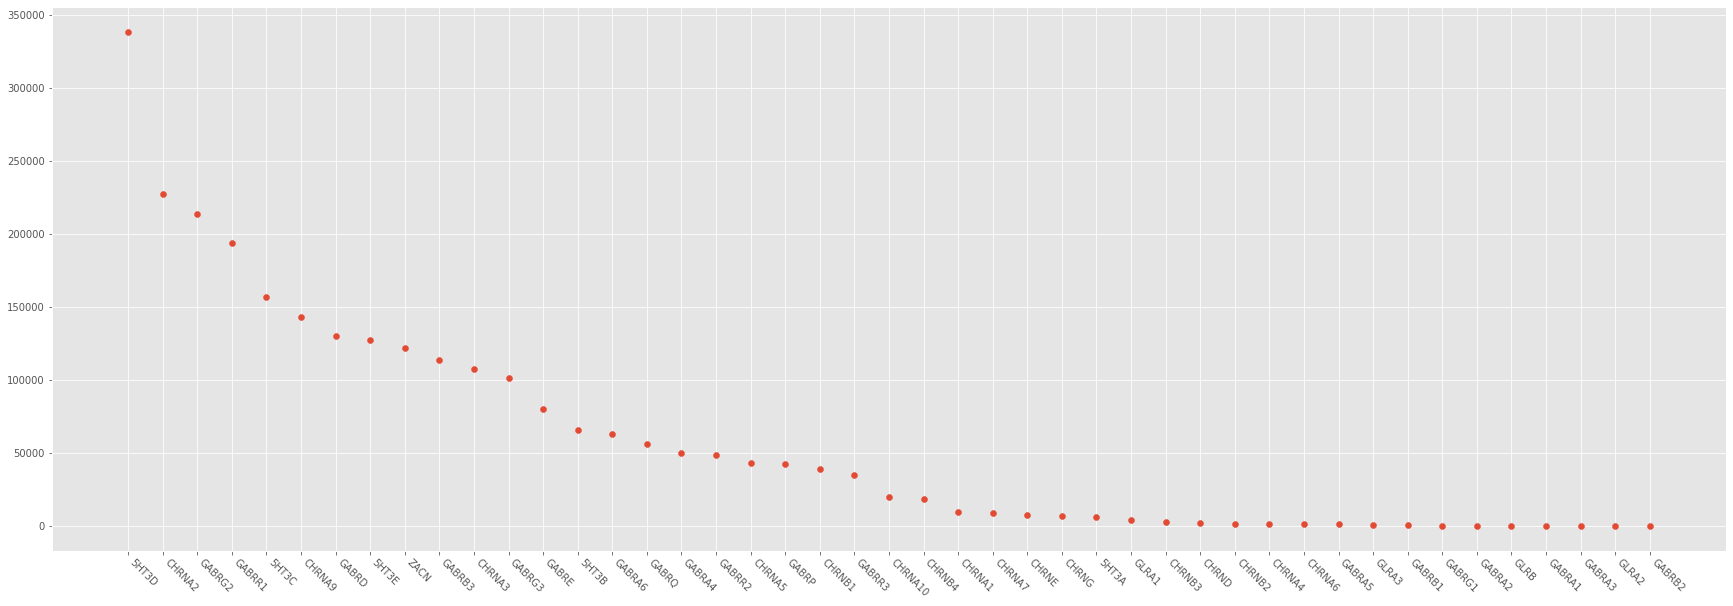

In [22]:
pyplot.scatter(_values["Gene"], _values["Allele Count"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.show()

## Extracting the AA number from missense variants
We extracted the numbering of amino acid from `Protein Sequence` column. Then we used UniProt for determining the lengths of all proteins and normalized the position of amino acids to the full protein lengths. For a more in-depth analysis we would need an alignment.

In [88]:
missense = subdata[subdata["VEP Annotation"] == "missense_variant"]
missense

,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,HGVS Consequence,Protein Consequence,...,Allele Count African/African-American,Allele Number African/African-American,Homozygote Count African/African-American,Hemizygote Count African/African-American,Allele Count European (non-Finnish),Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene,Transcript
330,X,152364513.0,rs746277466,T,A,gnomAD Genomes,NaN,PASS,p.Ile20Phe,p.Ile20Phe,...,13.0,30532.0,0.0,3.0,0.0,52998.0,0.0,0.0,GABRA3,NaN
335,X,152364537.0,rs61734348,T,A,gnomAD Genomes,NaN,PASS,p.Thr12Ser,p.Thr12Ser,...,128.0,30634.0,0.0,38.0,5.0,53119.0,0.0,2.0,GABRA3,NaN
400,5,161850837.0,rs113886269,C,A,gnomAD Genomes,NaN,PASS,p.Asp9Glu,p.Asp9Glu,...,113.0,41444.0,0.0,0.0,2.0,68030.0,0.0,0.0,GABRA1,NaN
492,5,161854168.0,rs143815396,C,T,gnomAD Genomes,NaN,PASS,p.Pro29Ser,p.Pro29Ser,...,19.0,41228.0,0.0,0.0,0.0,67638.0,0.0,0.0,GABRA1,NaN
880,5,161897276.0,rs139793542,C,T,gnomAD Genomes,NaN,PASS,p.Pro409Ser,p.Pro409Ser,...,16.0,41450.0,0.0,0.0,0.0,68036.0,0.0,0.0,GABRA1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28617,2,232544781.0,rs146674765,C,T,gnomAD Genomes,NaN,PASS,p.Pro420Leu,p.Pro420Leu,...,48.0,41416.0,0.0,0.0,1.0,68016.0,0.0,0.0,CHRNG,ENST00000651502.1
28646,2,232544900.0,rs138232636,A,G,gnomAD Genomes,NaN,PASS,p.Asn460Asp,p.Asn460Asp,...,5.0,41398.0,0.0,0.0,10.0,67994.0,0.0,0.0,CHRNG,ENST00000651502.1
28684,2,232545543.0,rs143800157,G,A,gnomAD Genomes,NaN,PASS,p.Gly461Arg,p.Gly461Arg,...,0.0,41448.0,0.0,0.0,6.0,68032.0,0.0,0.0,CHRNG,ENST00000651502.1
28691,2,232545583.0,rs16829216,G,A,gnomAD Genomes,NaN,PASS,p.Arg474His,p.Arg474His,...,4.0,41438.0,0.0,0.0,11.0,68024.0,0.0,0.0,CHRNG,ENST00000651502.1


In [89]:
missense["AA Number"] = missense["Protein Consequence"].str.extract(r"[a-zA-Z]([0-9]+)[a-zA-Z]").astype("int32")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [90]:
print(*list(missense["Gene"].unique()), sep='\": \n\"')

GABRA3": 
"GABRA1": 
"CHRNA3": 
"GABRP": 
"CHRNA4": 
"GLRA2": 
"GABRE": 
"GABRA4": 
"GLRB": 
"GABRR2": 
"GABRG2": 
"CHRNA2": 
"CHRNA1": 
"GLRA3": 
"GABRA6": 
"GABRB2": 
"GLRA1": 
"GABRR1": 
"CHRNA6": 
"5HT3B": 
"GABRA2": 
"GABRG1": 
"GABRB1": 
"GABRB3": 
"5HT3A": 
"CHRNA5": 
"5HT3C": 
"GABRG3": 
"GABRR3": 
"5HT3E": 
"5HT3D": 
"GABRA5": 
"ZACN": 
"GABRD": 
"GABRQ": 
"CHRNE": 
"CHRNB4": 
"CHRNA10": 
"CHRND": 
"CHRNB3": 
"CHRNB2": 
"CHRNB1": 
"CHRNA9": 
"CHRNA7": 
"CHRNG


In [91]:
missense["AA Relative"] = 0
# Lengths are taken from UniProt
lengths = {
    "GABRA3": 492,
    "GABRA1": 456,
    "CHRNA3": 505,
    "GABRP": 440,
    "CHRNA4": 627,
    "GLRA2": 452,
    "GABRE": 506,
    "GABRA4": 554, 
    "GLRB": 497,
    "GABRR2": 465,
    "GABRG2": 467,
    "CHRNA2": 529,
    "CHRNA1": 482,
    "GLRA3": 464,
    "GABRA6": 453,
    "GABRB2": 512,
    "GLRA1": 457,
    "GABRR1": 479,
    "CHRNA6": 494,
    "5HT3B": 441,
    "GABRA2": 451,
    "GABRG1": 465,
    "GABRB1": 474,
    "GABRB3": 473,
    "5HT3A": 478,
    "CHRNA5": 468,
    "5HT3C": 447,
    "GABRG3": 467,
    "GABRR3": 467,
    "5HT3E": 456,
    "5HT3D": 454,
    "GABRA5": 462,
    "ZACN": 412,
    "GABRD": 452,
    "GABRQ": 632,
    "CHRNE": 493,
    "CHRNB4": 498,
    "CHRNA10": 450,
    "CHRND": 517,
    "CHRNB3": 458,
    "CHRNB2": 502,
    "CHRNB1": 501,
    "CHRNA9": 479,
    "CHRNA7": 502,
    "CHRNG": 517,
}
for gene in missense["Gene"].unique():
    missense["AA Relative"][missense["Gene"] == gene] = missense["AA Number"][missense["Gene"] == gene] / lengths[gene]
missense 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,HGVS Consequence,Protein Consequence,...,Homozygote Count African/African-American,Hemizygote Count African/African-American,Allele Count European (non-Finnish),Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene,Transcript,AA Number,AA Relative
330,X,152364513.0,rs746277466,T,A,gnomAD Genomes,NaN,PASS,p.Ile20Phe,p.Ile20Phe,...,0.0,3.0,0.0,52998.0,0.0,0.0,GABRA3,NaN,20,0.040650
335,X,152364537.0,rs61734348,T,A,gnomAD Genomes,NaN,PASS,p.Thr12Ser,p.Thr12Ser,...,0.0,38.0,5.0,53119.0,0.0,2.0,GABRA3,NaN,12,0.024390
400,5,161850837.0,rs113886269,C,A,gnomAD Genomes,NaN,PASS,p.Asp9Glu,p.Asp9Glu,...,0.0,0.0,2.0,68030.0,0.0,0.0,GABRA1,NaN,9,0.019737
492,5,161854168.0,rs143815396,C,T,gnomAD Genomes,NaN,PASS,p.Pro29Ser,p.Pro29Ser,...,0.0,0.0,0.0,67638.0,0.0,0.0,GABRA1,NaN,29,0.063596
880,5,161897276.0,rs139793542,C,T,gnomAD Genomes,NaN,PASS,p.Pro409Ser,p.Pro409Ser,...,0.0,0.0,0.0,68036.0,0.0,0.0,GABRA1,NaN,409,0.896930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28617,2,232544781.0,rs146674765,C,T,gnomAD Genomes,NaN,PASS,p.Pro420Leu,p.Pro420Leu,...,0.0,0.0,1.0,68016.0,0.0,0.0,CHRNG,ENST00000651502.1,420,0.812379
28646,2,232544900.0,rs138232636,A,G,gnomAD Genomes,NaN,PASS,p.Asn460Asp,p.Asn460Asp,...,0.0,0.0,10.0,67994.0,0.0,0.0,CHRNG,ENST00000651502.1,460,0.889749
28684,2,232545543.0,rs143800157,G,A,gnomAD Genomes,NaN,PASS,p.Gly461Arg,p.Gly461Arg,...,0.0,0.0,6.0,68032.0,0.0,0.0,CHRNG,ENST00000651502.1,461,0.891683
28691,2,232545583.0,rs16829216,G,A,gnomAD Genomes,NaN,PASS,p.Arg474His,p.Arg474His,...,0.0,0.0,11.0,68024.0,0.0,0.0,CHRNG,ENST00000651502.1,474,0.916828


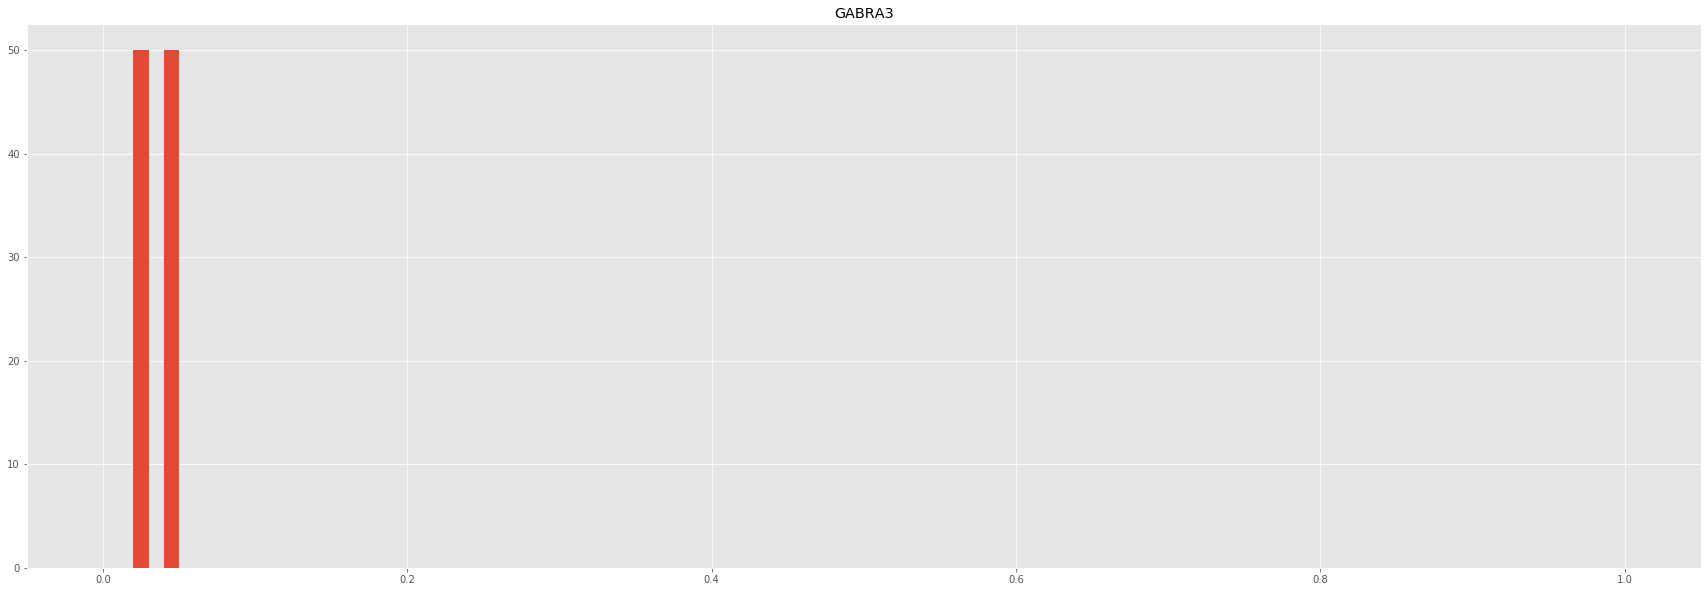

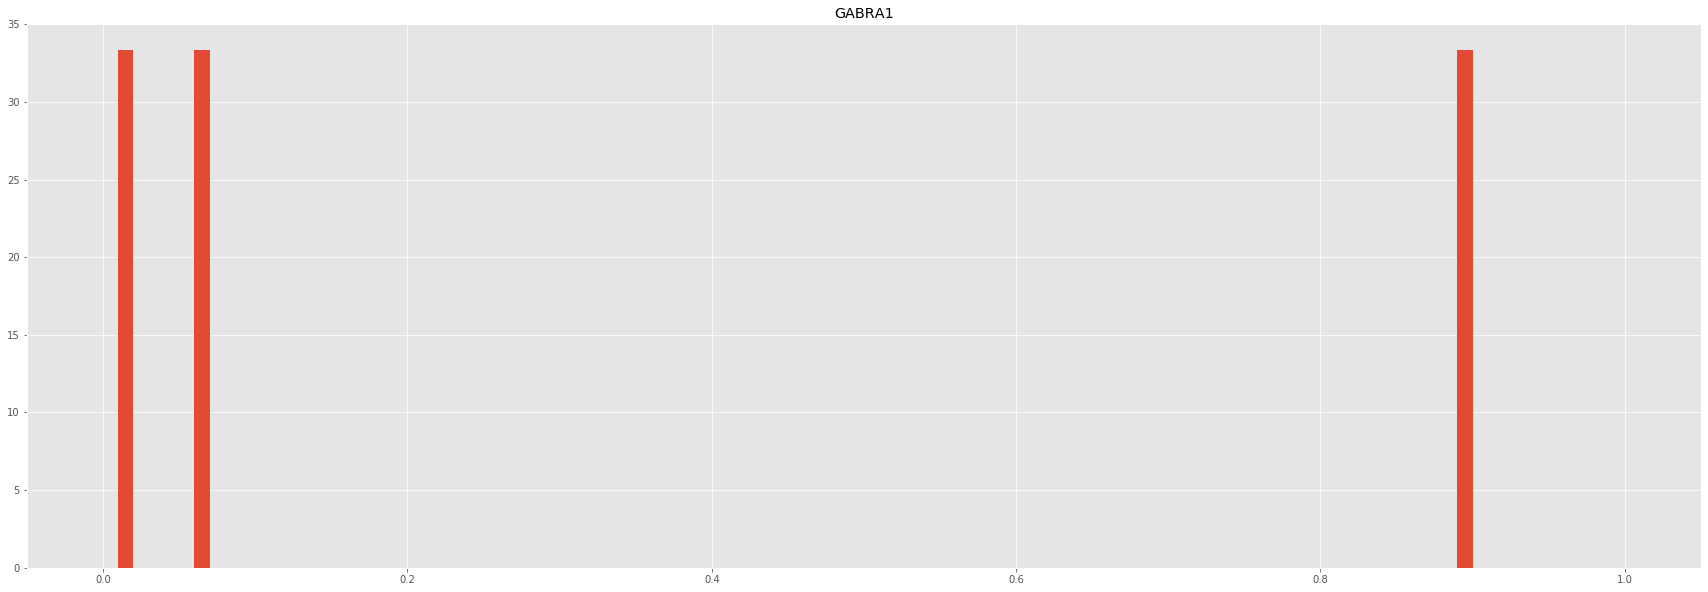

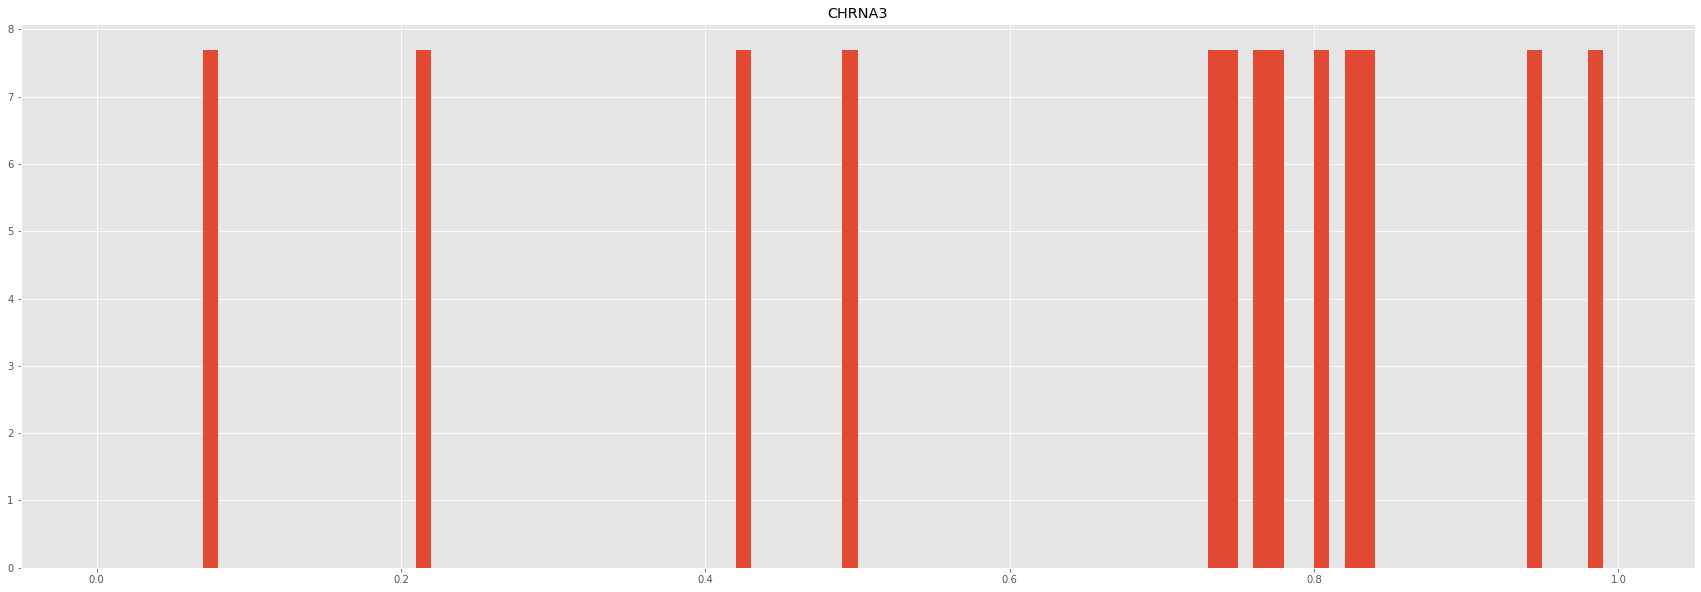

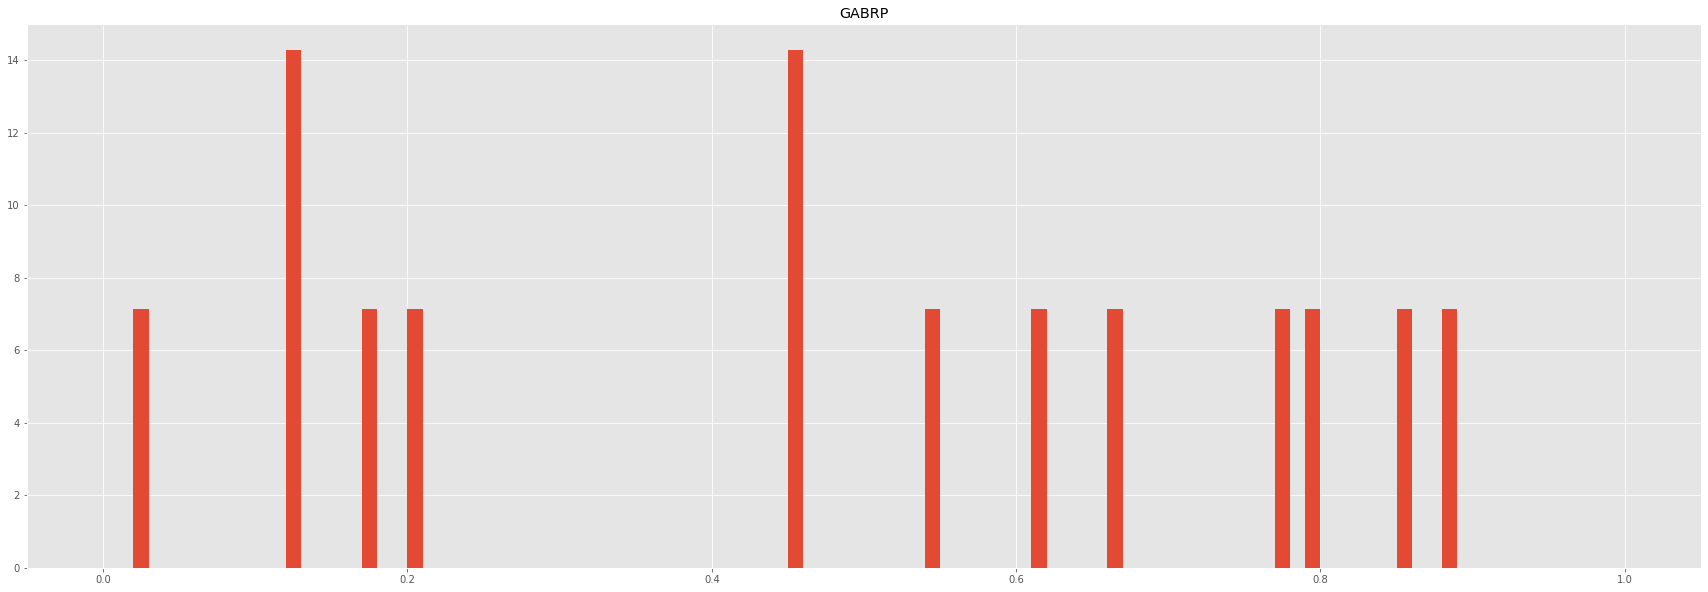

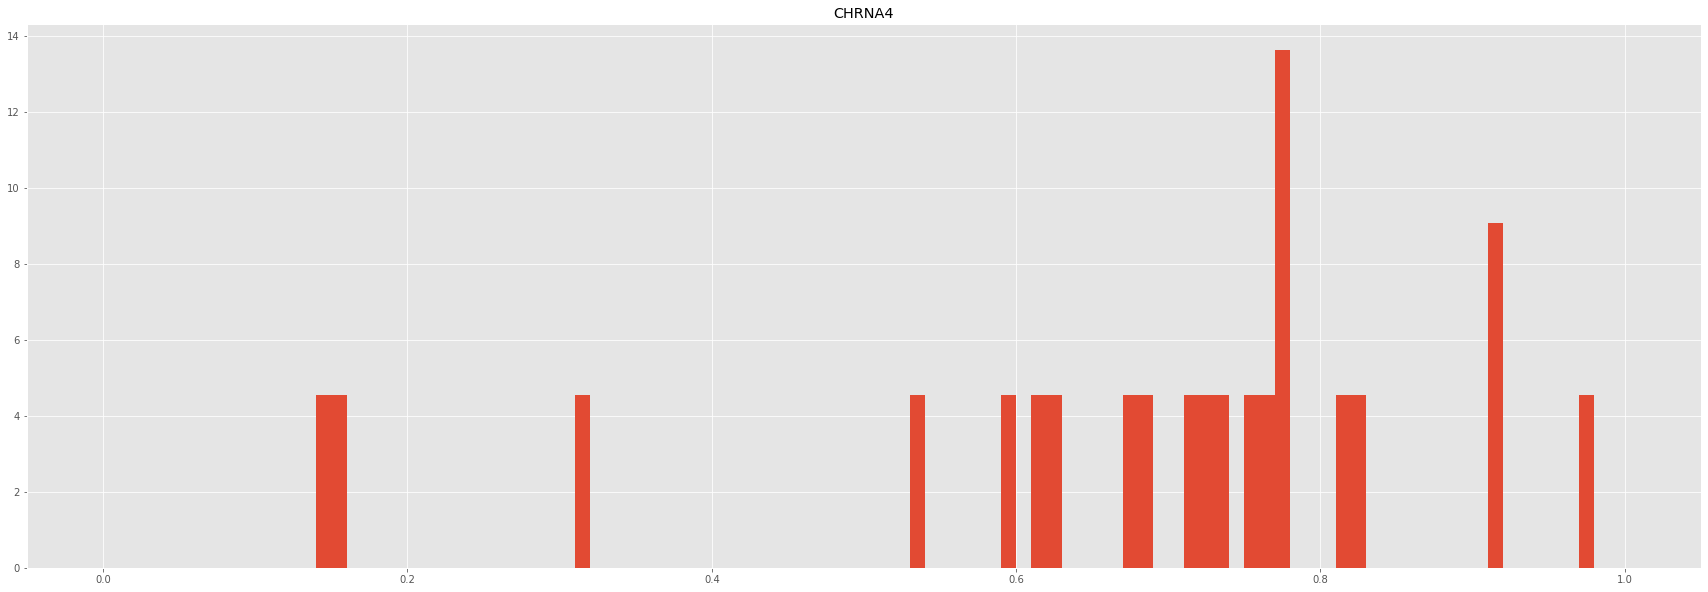

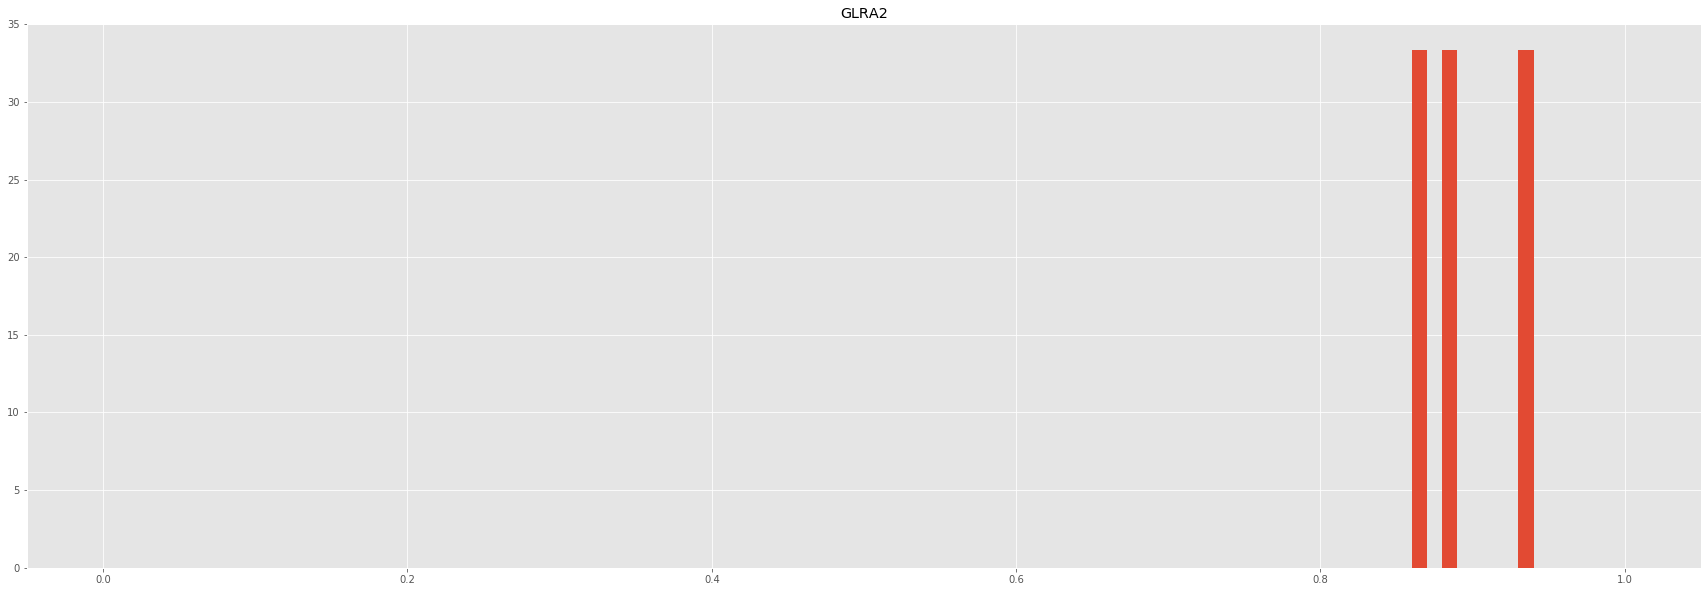

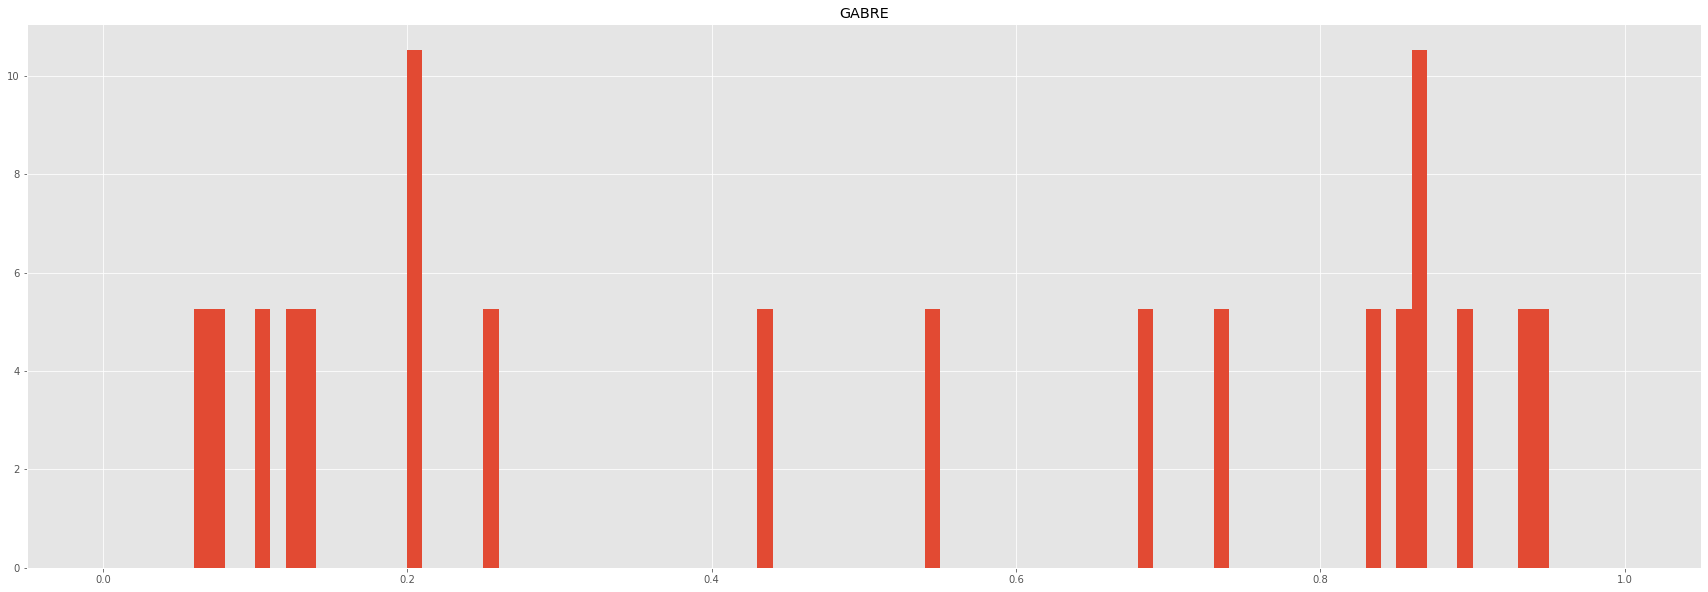

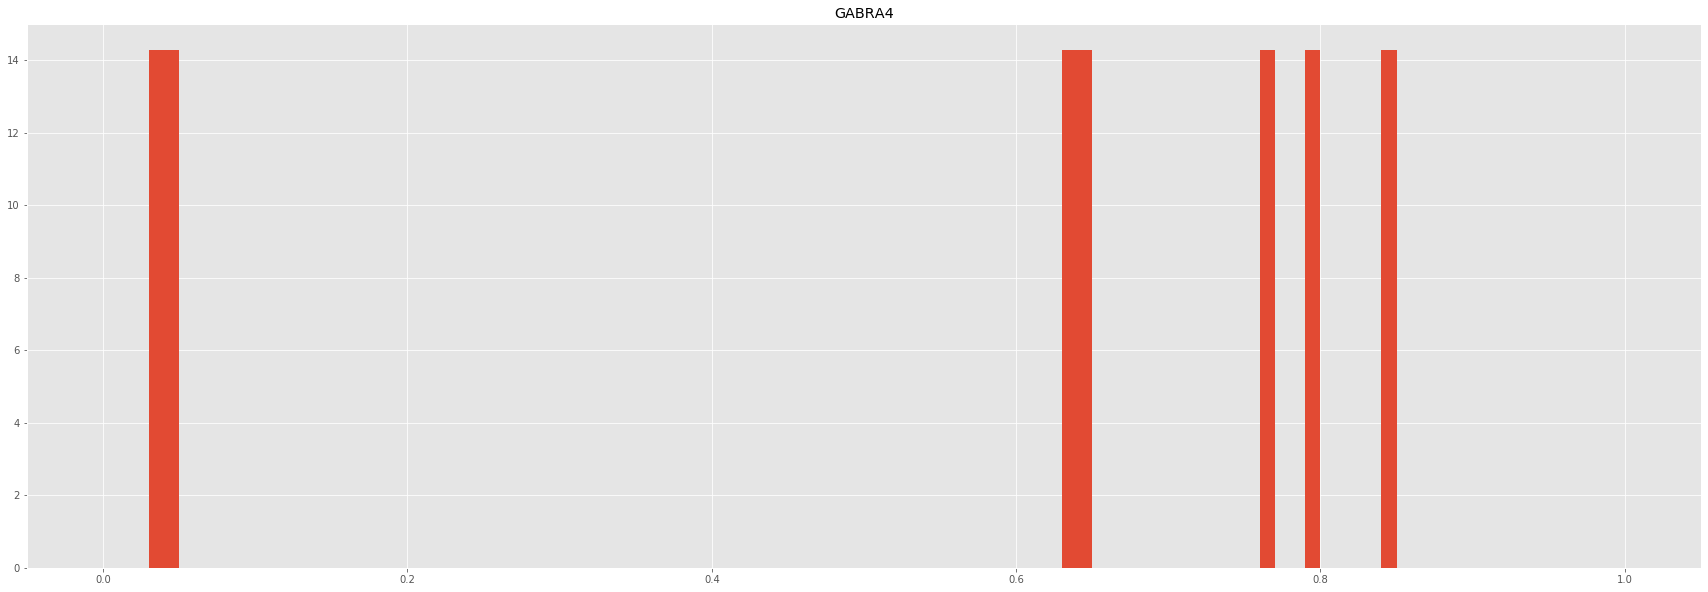

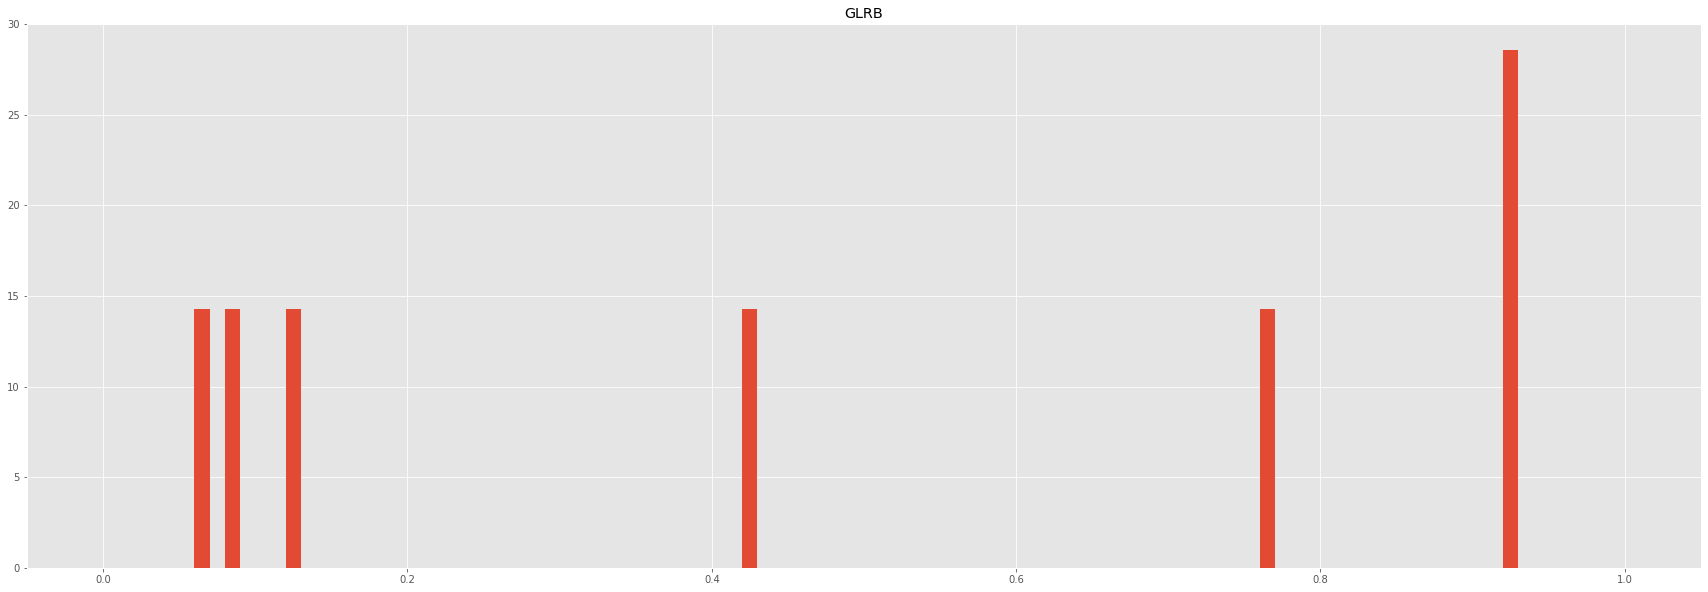

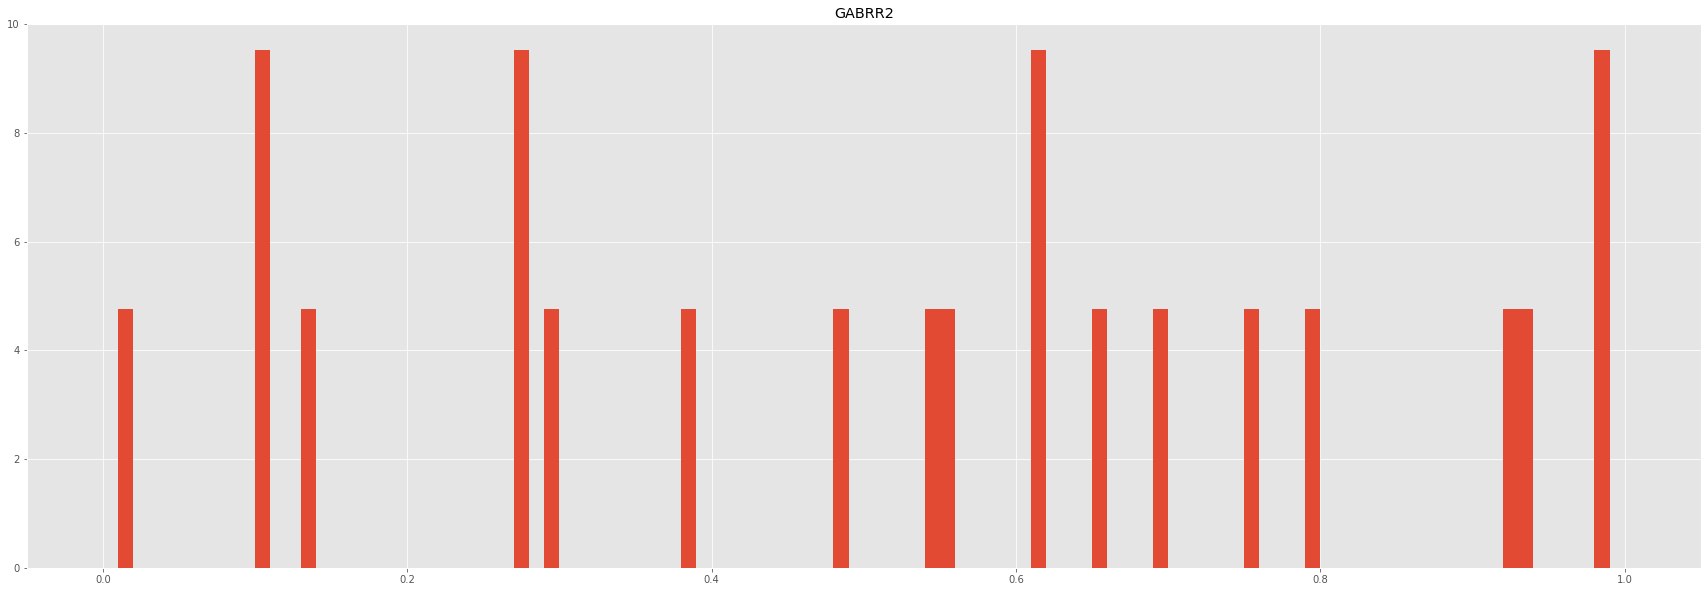

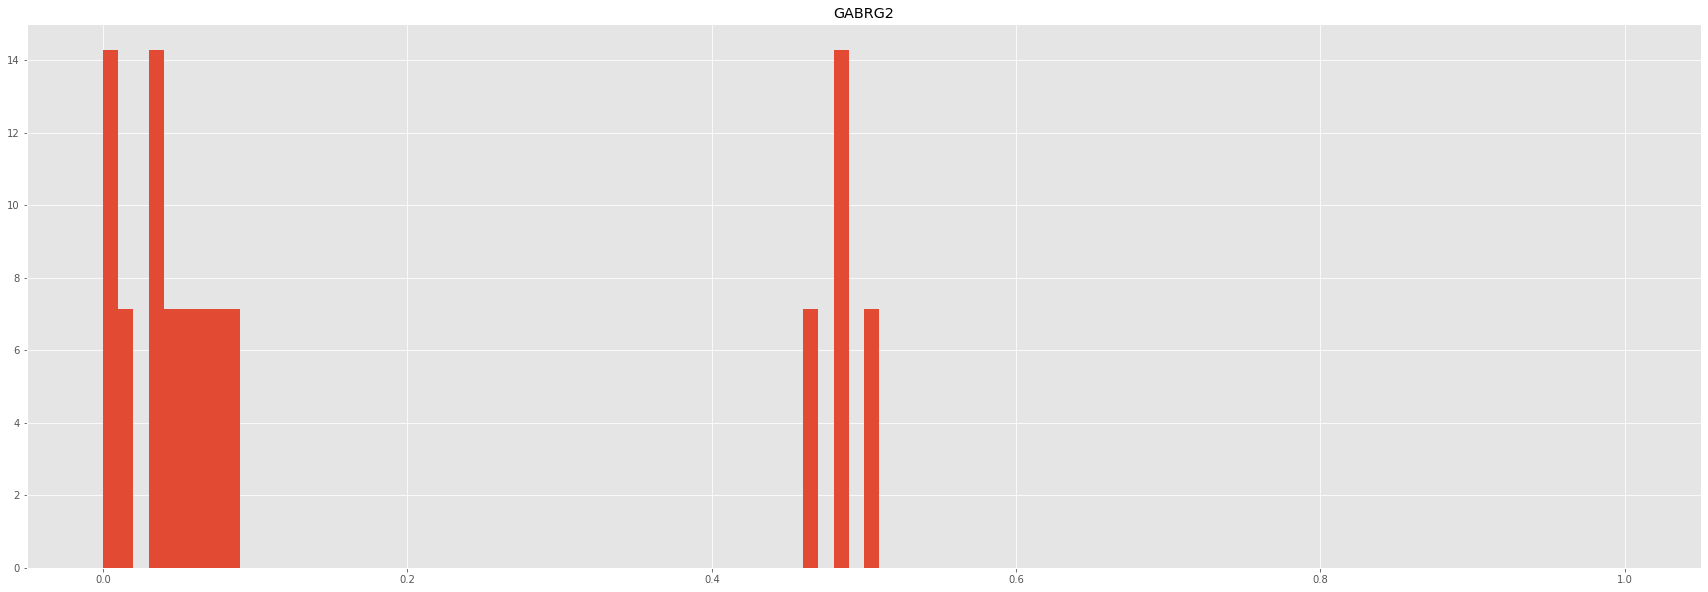

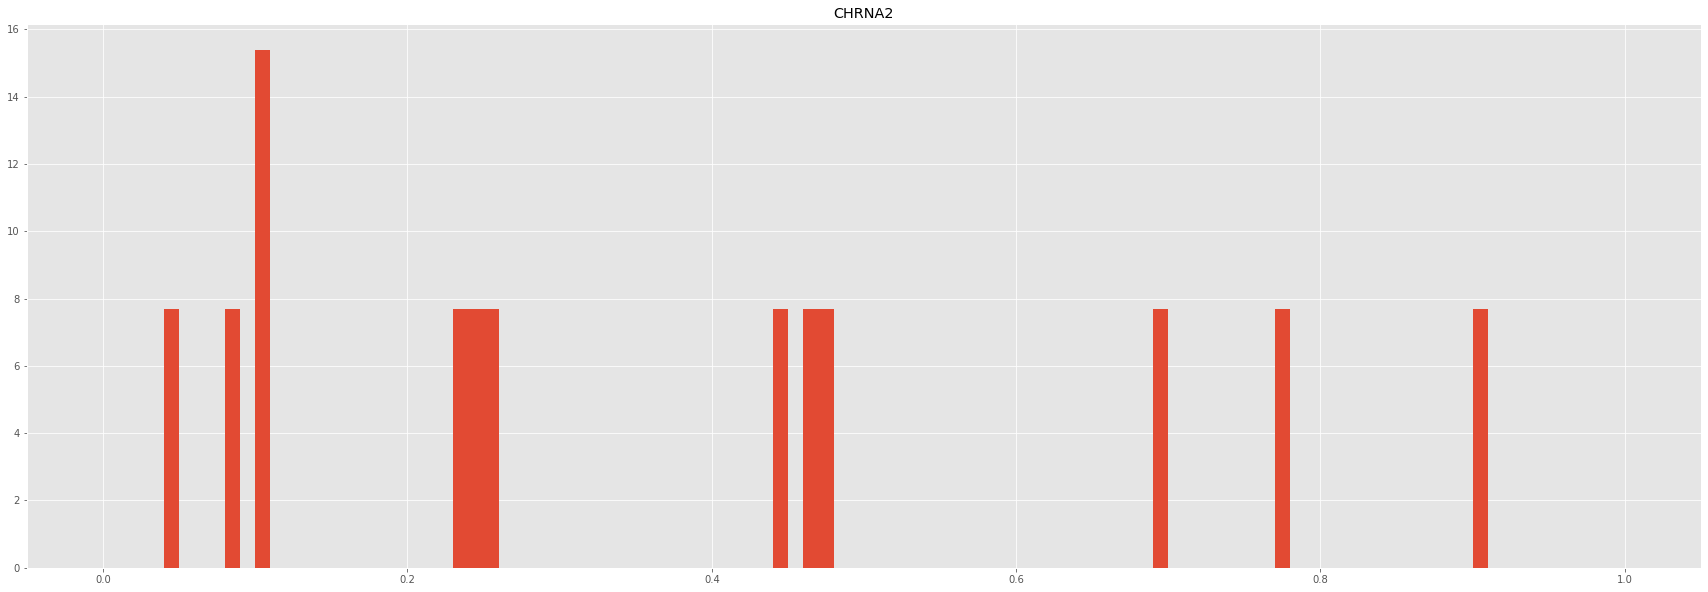

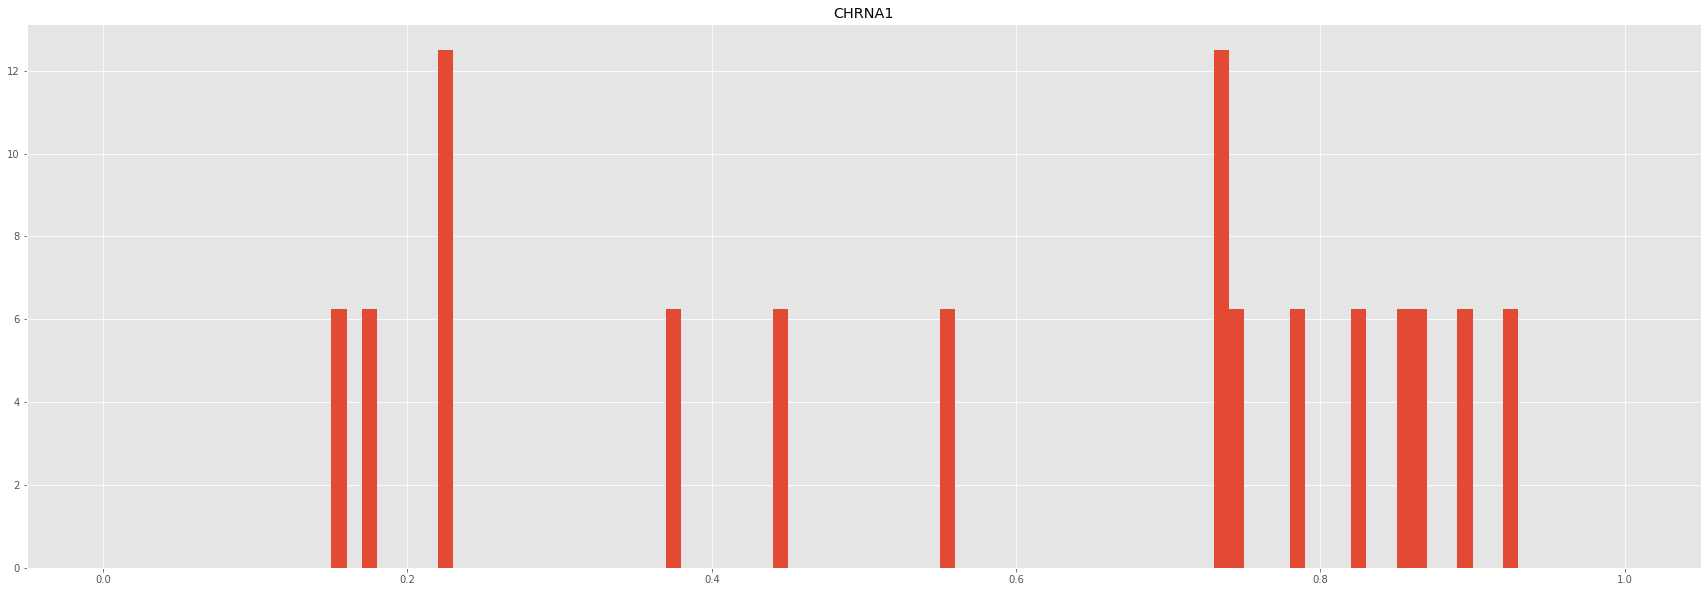

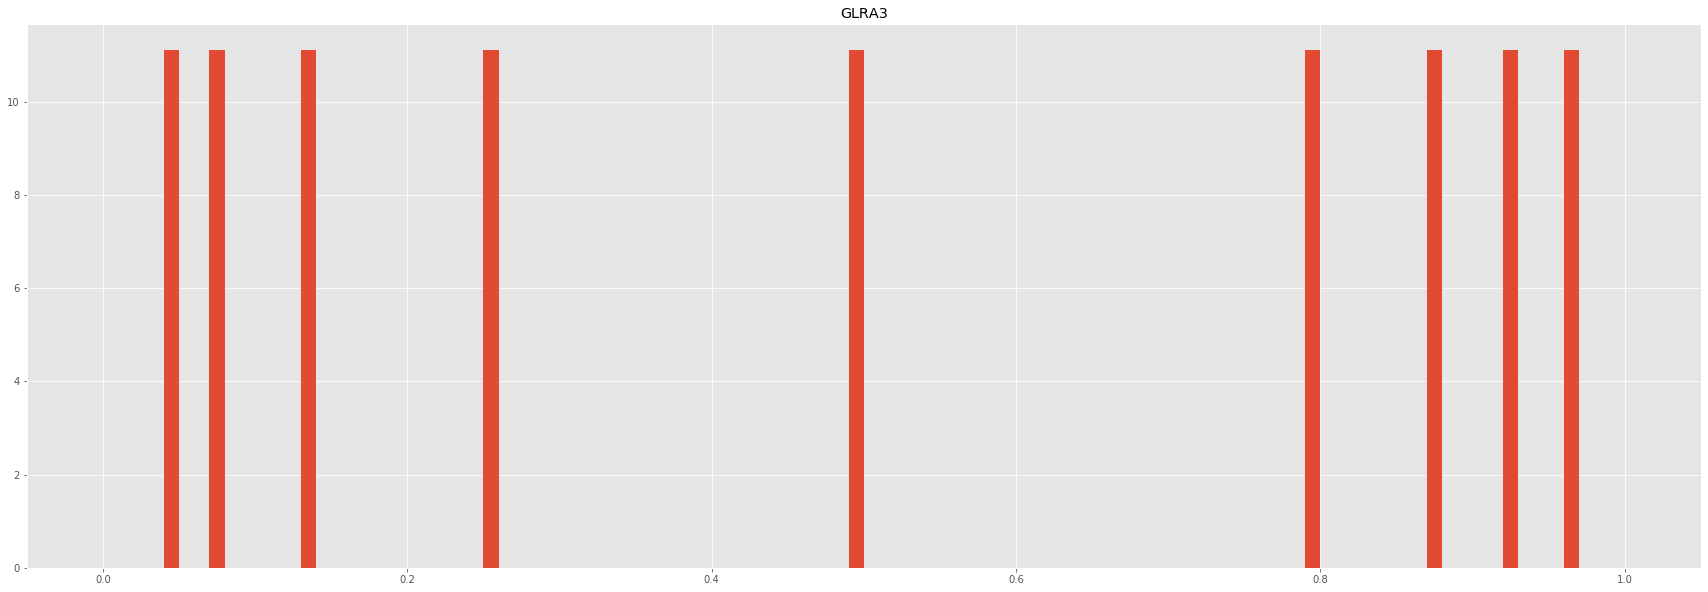

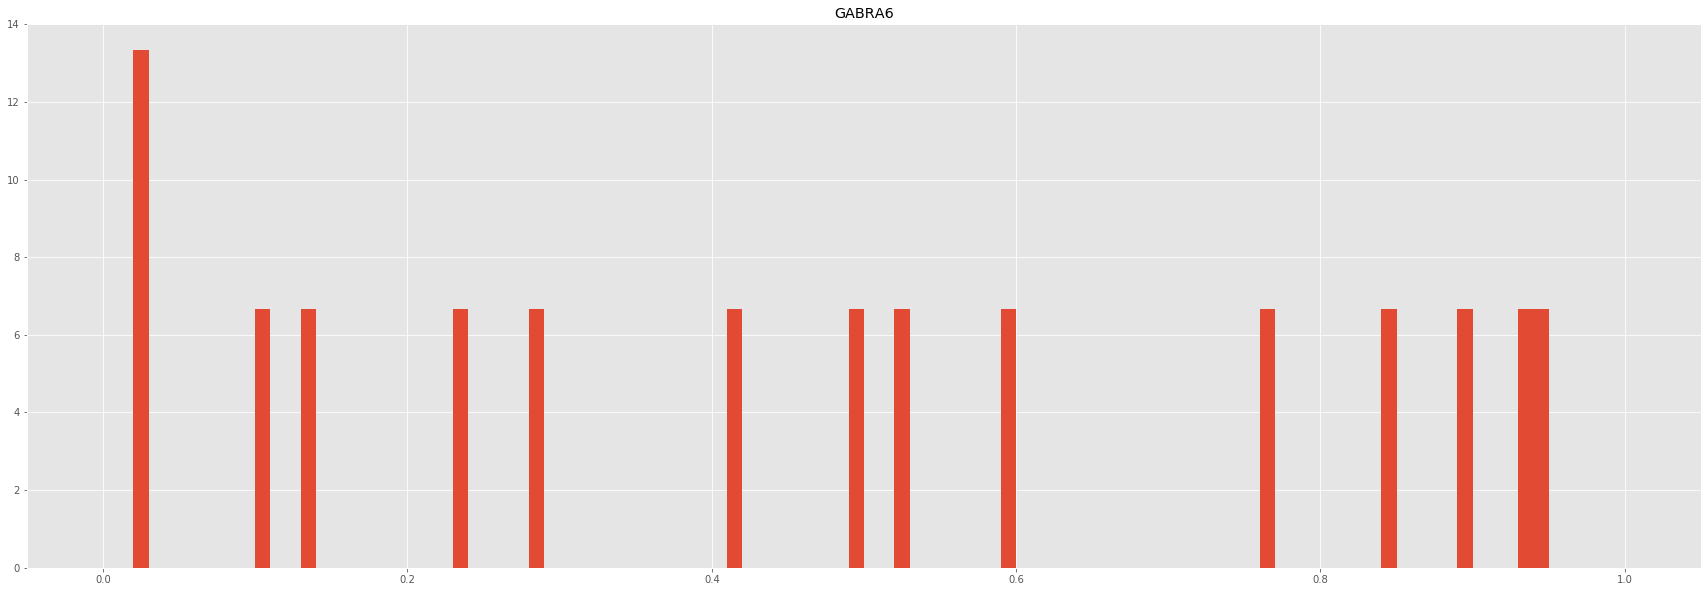

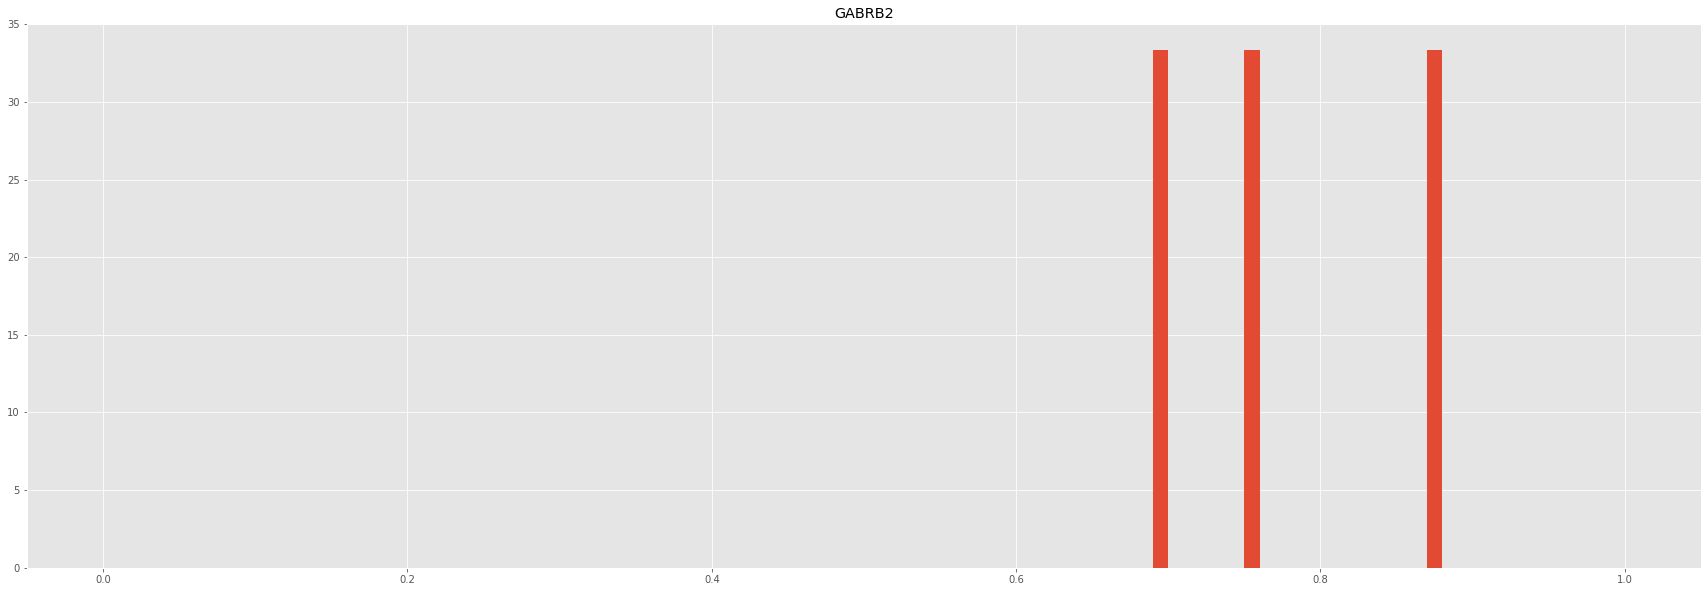

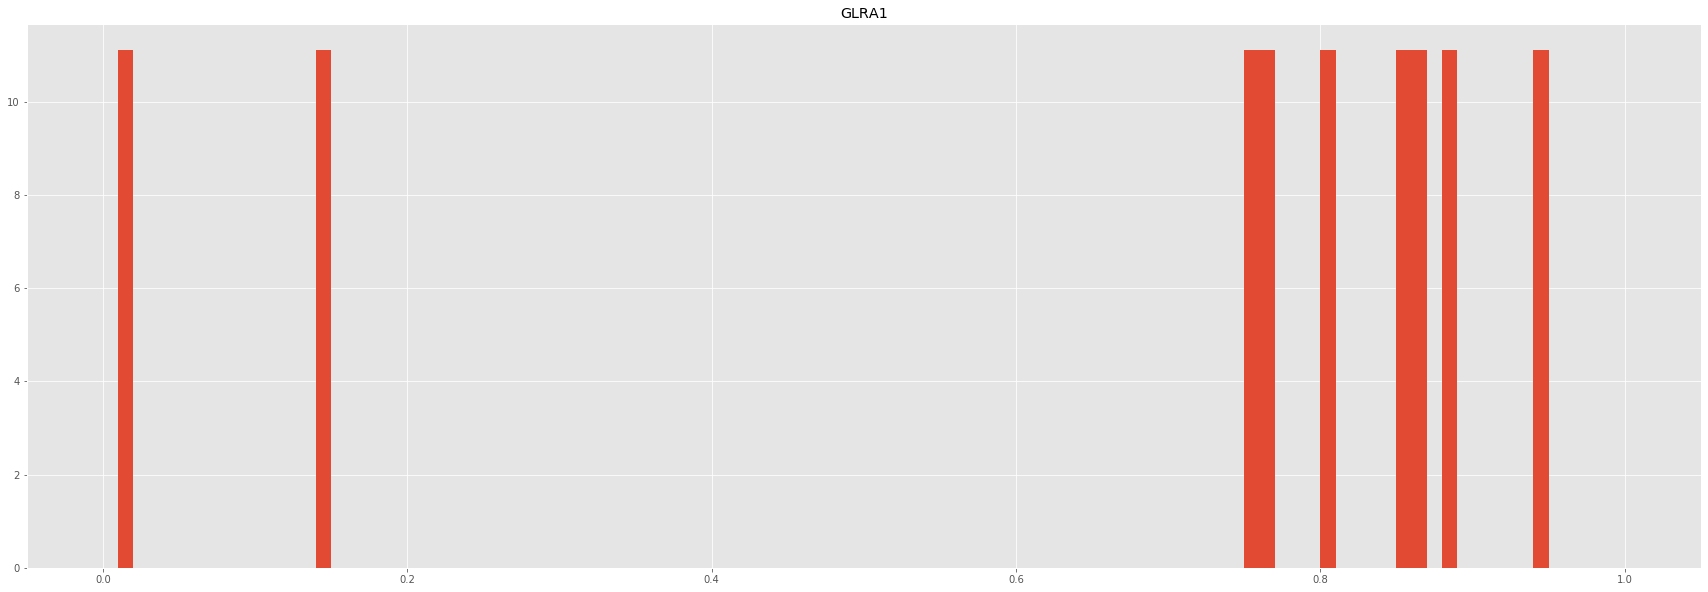

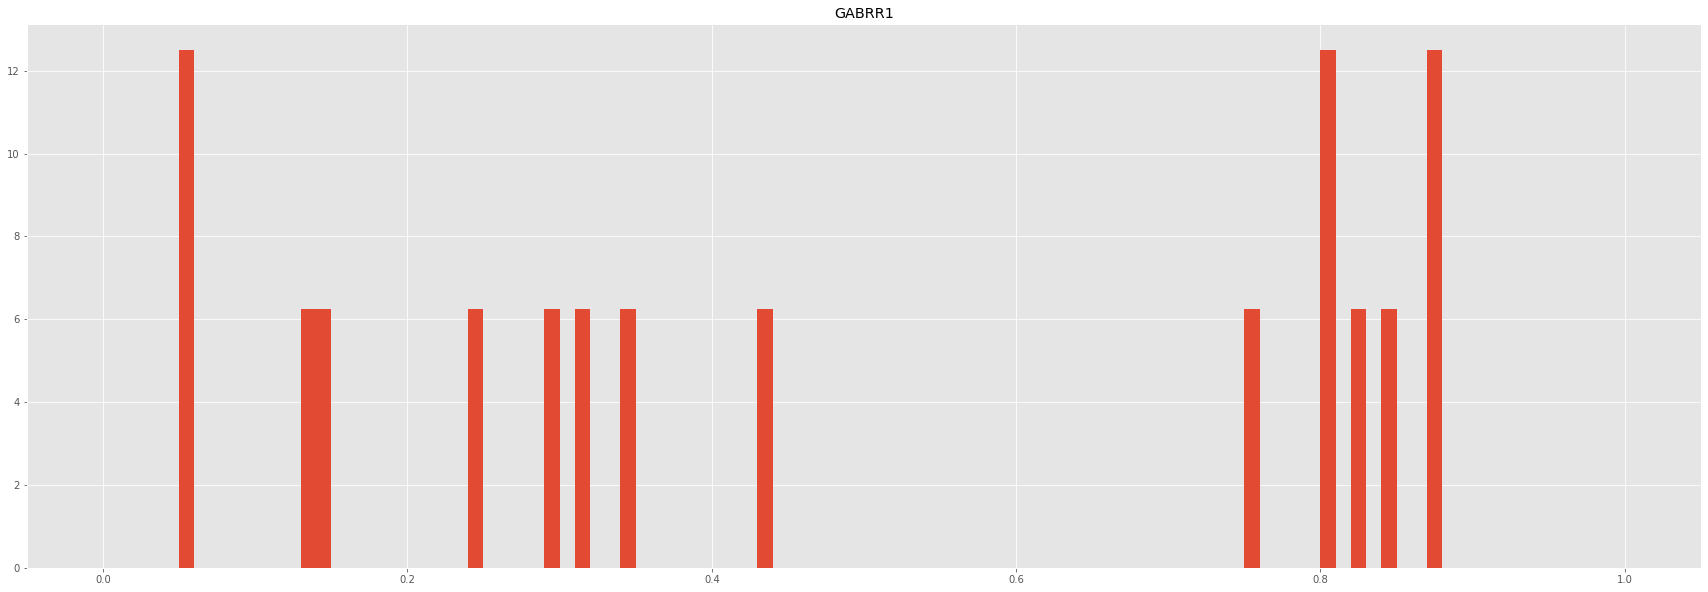

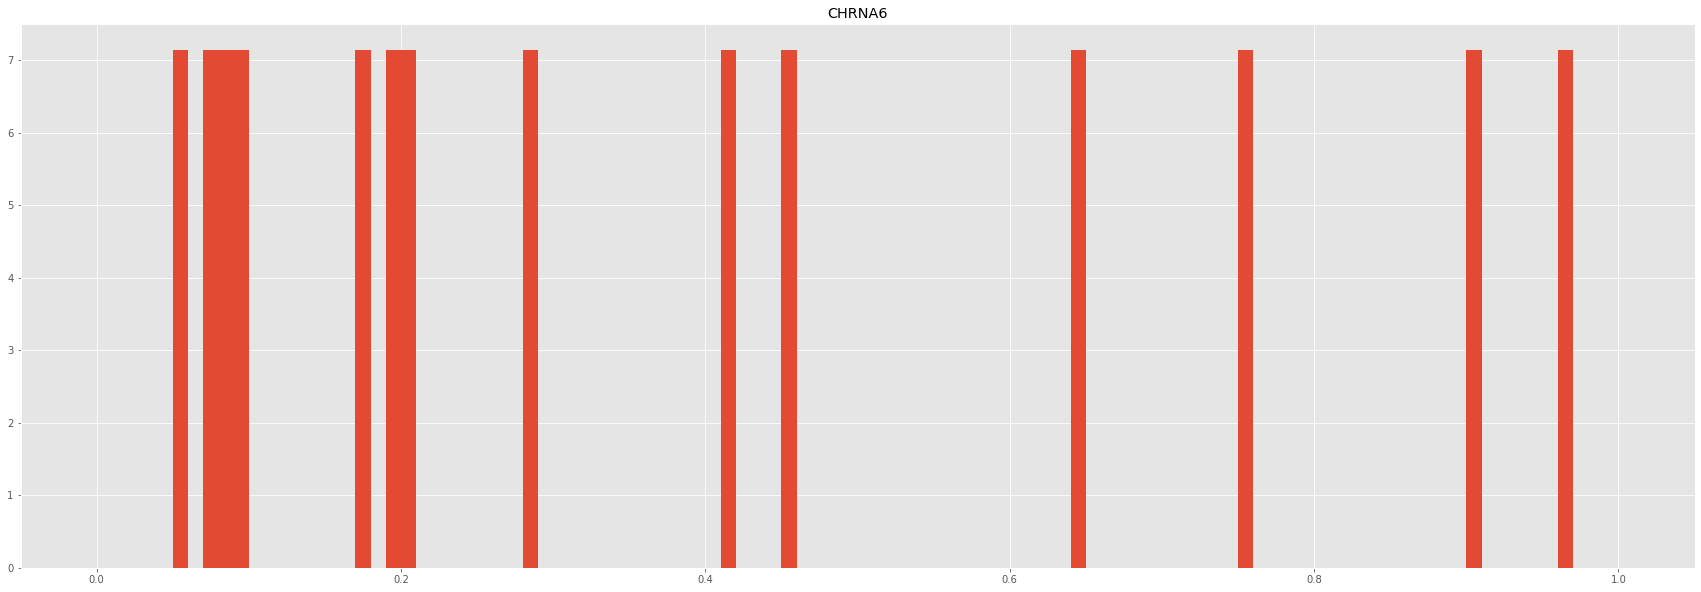

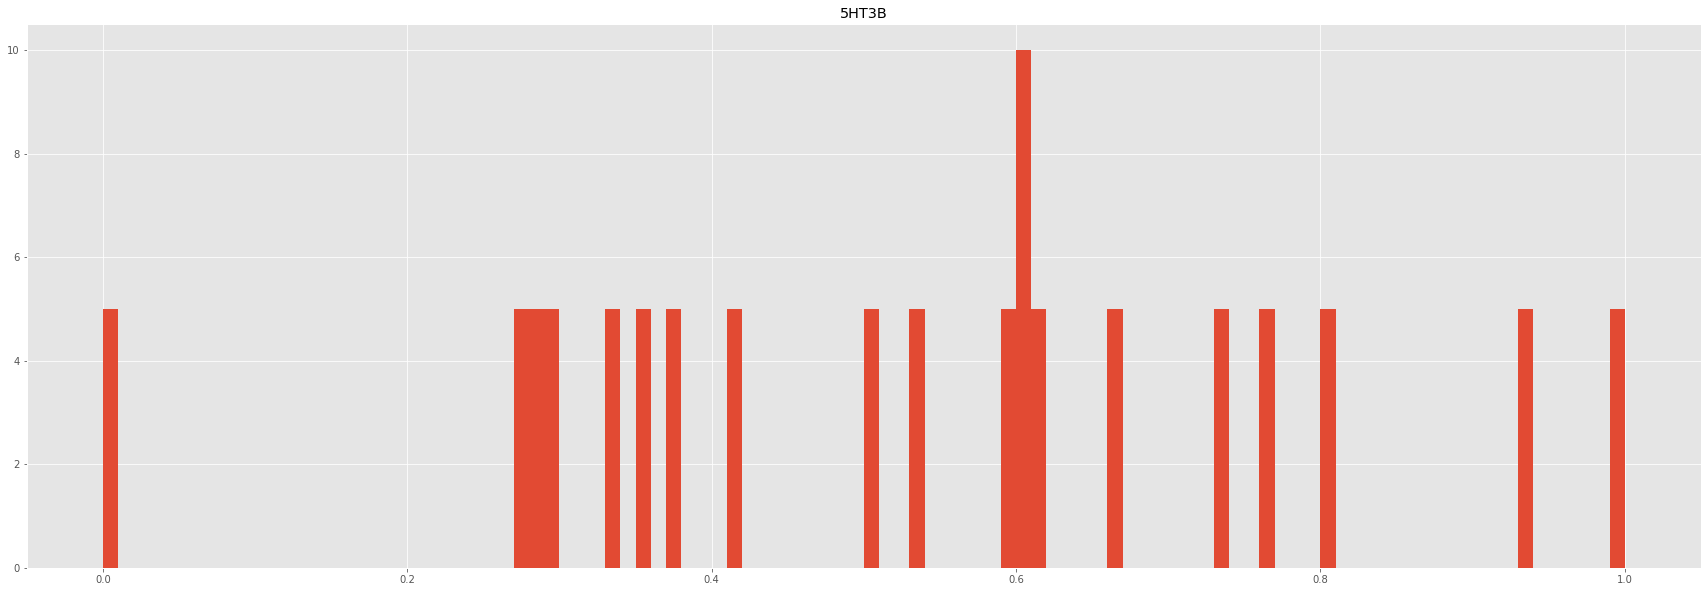

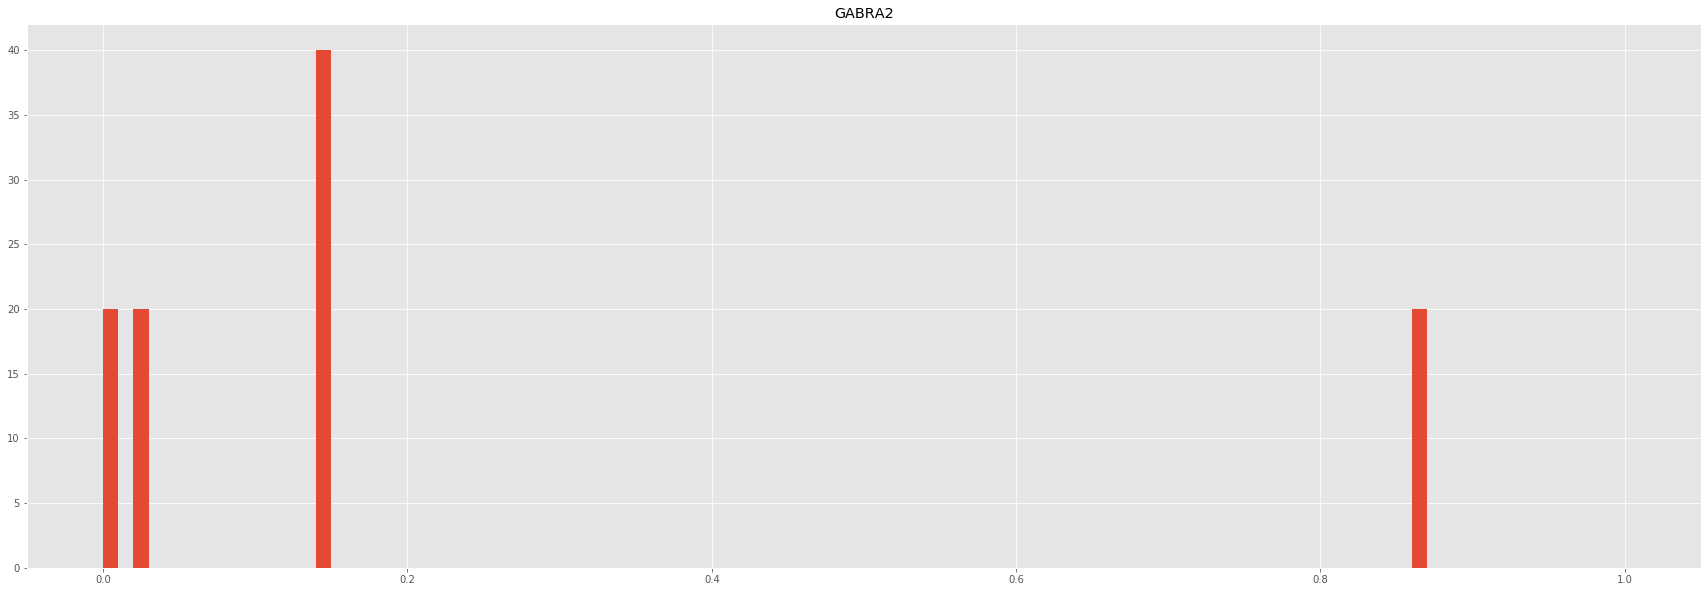

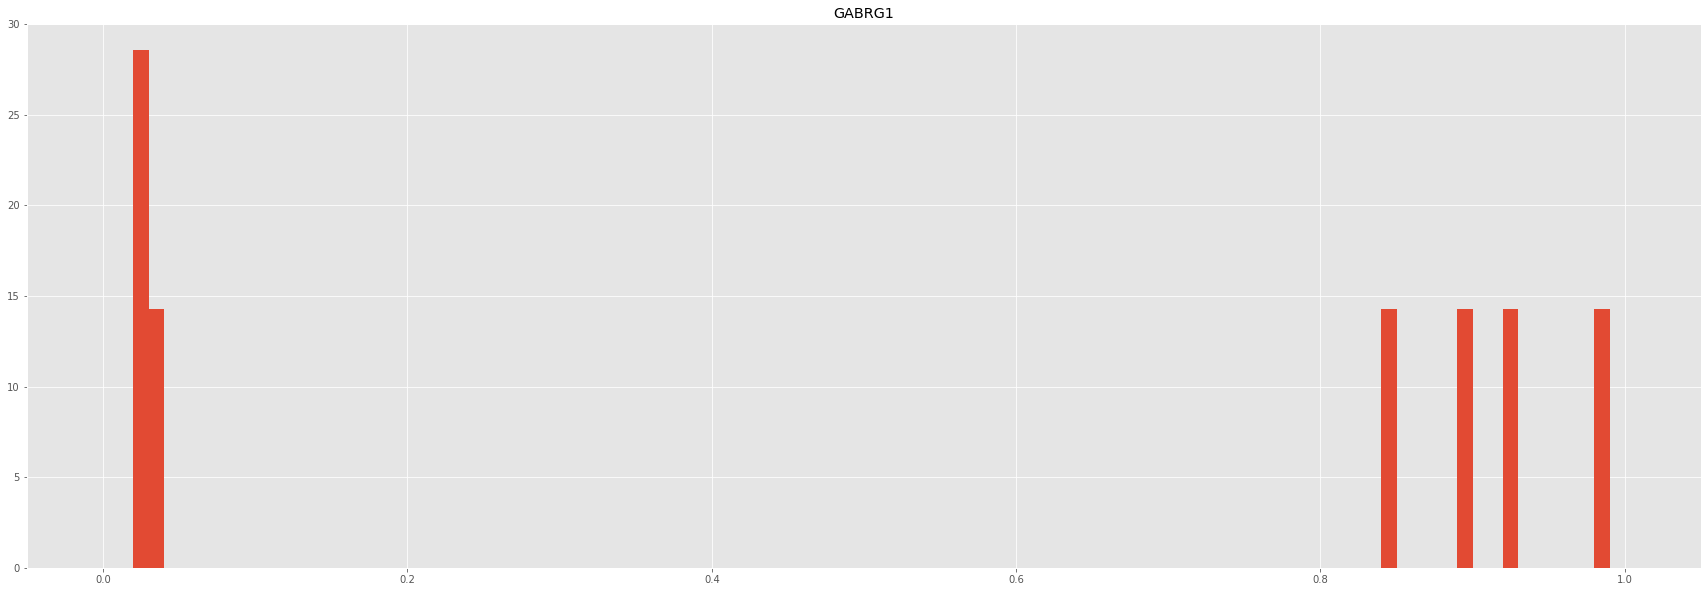

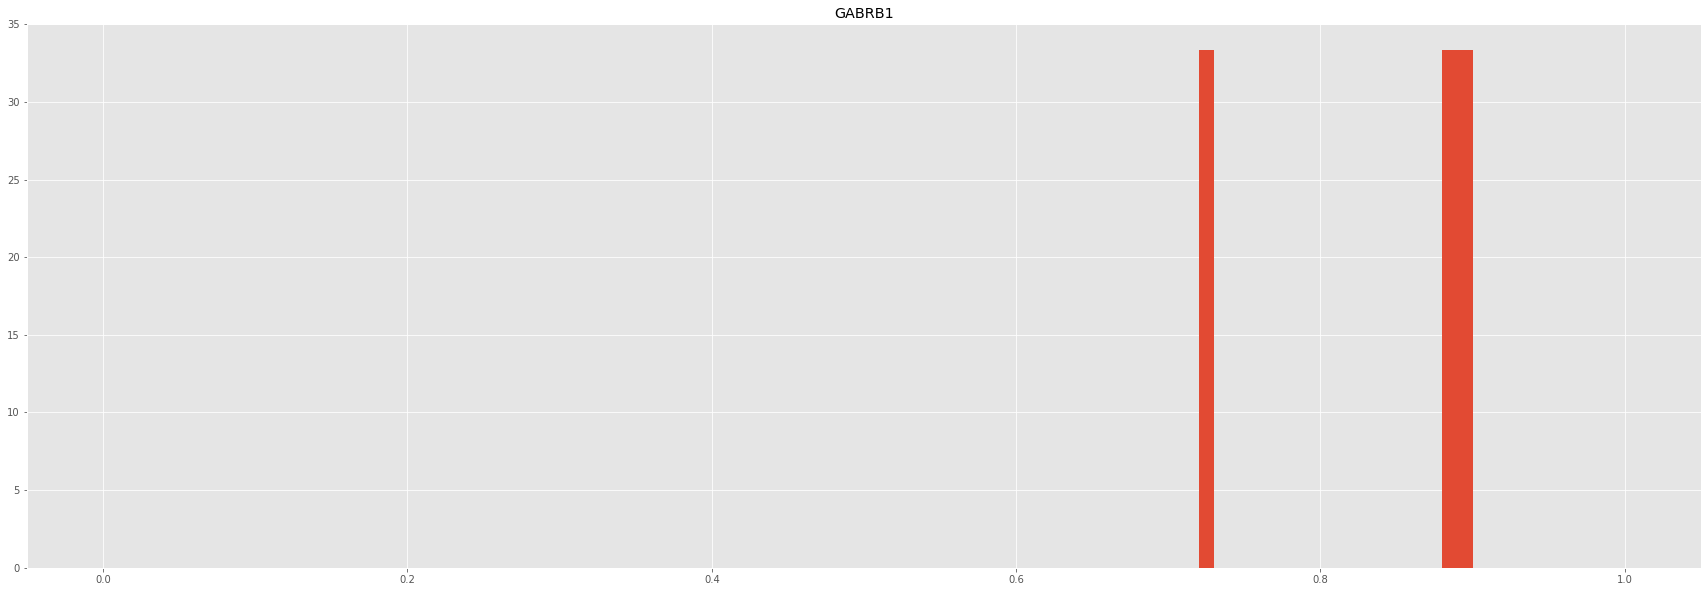

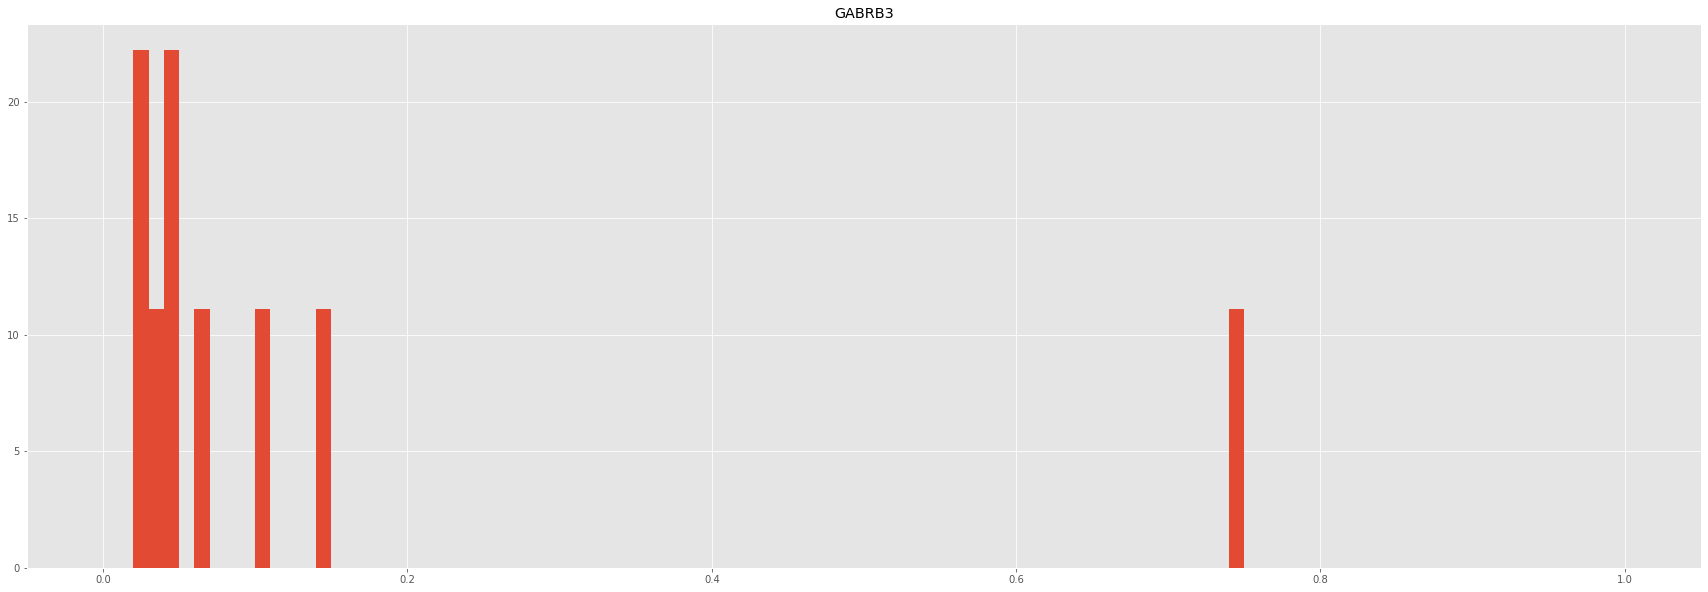

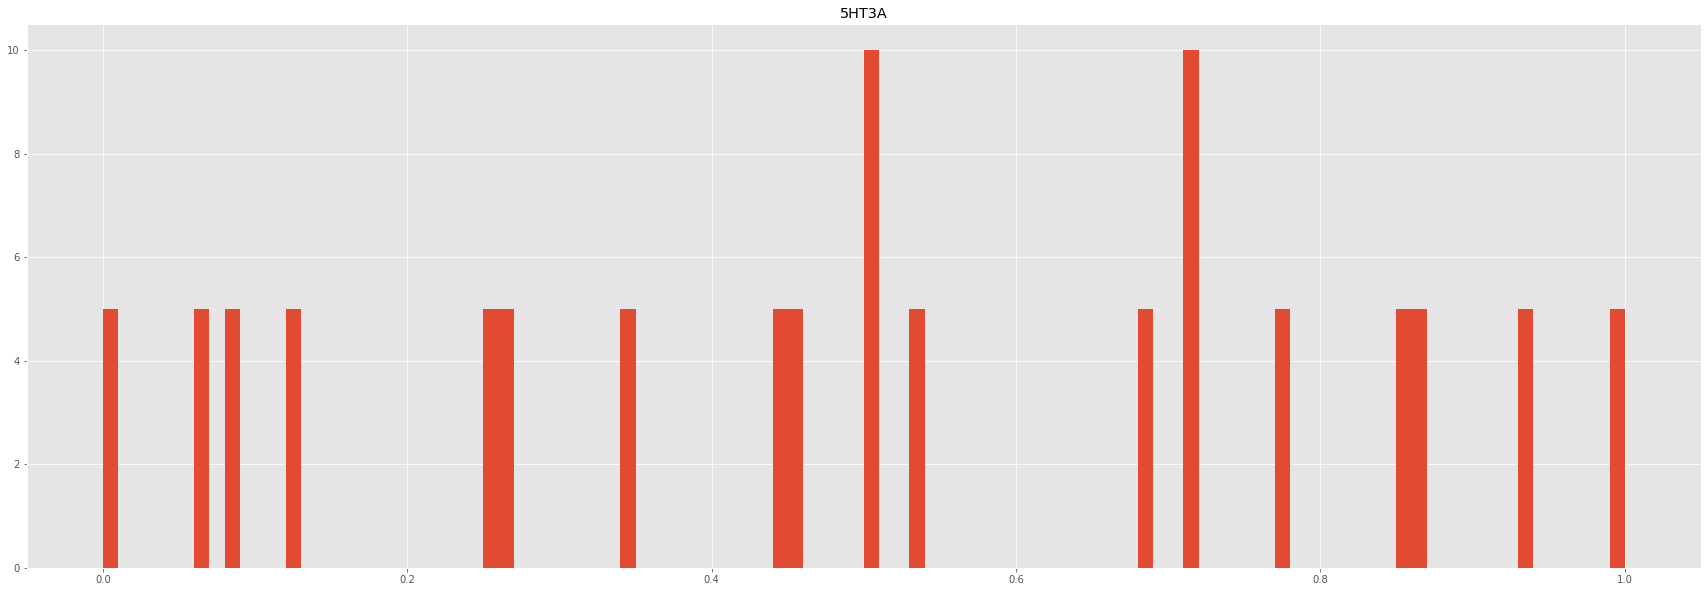

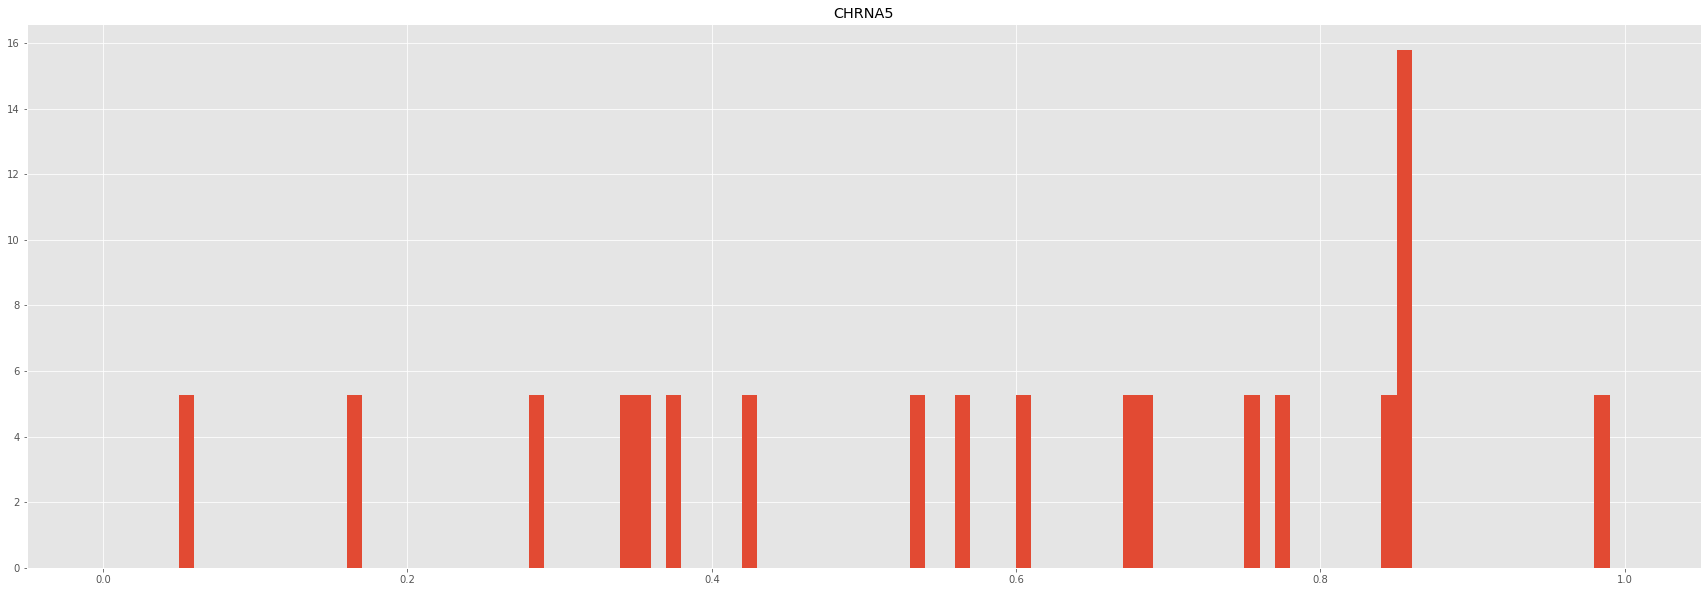

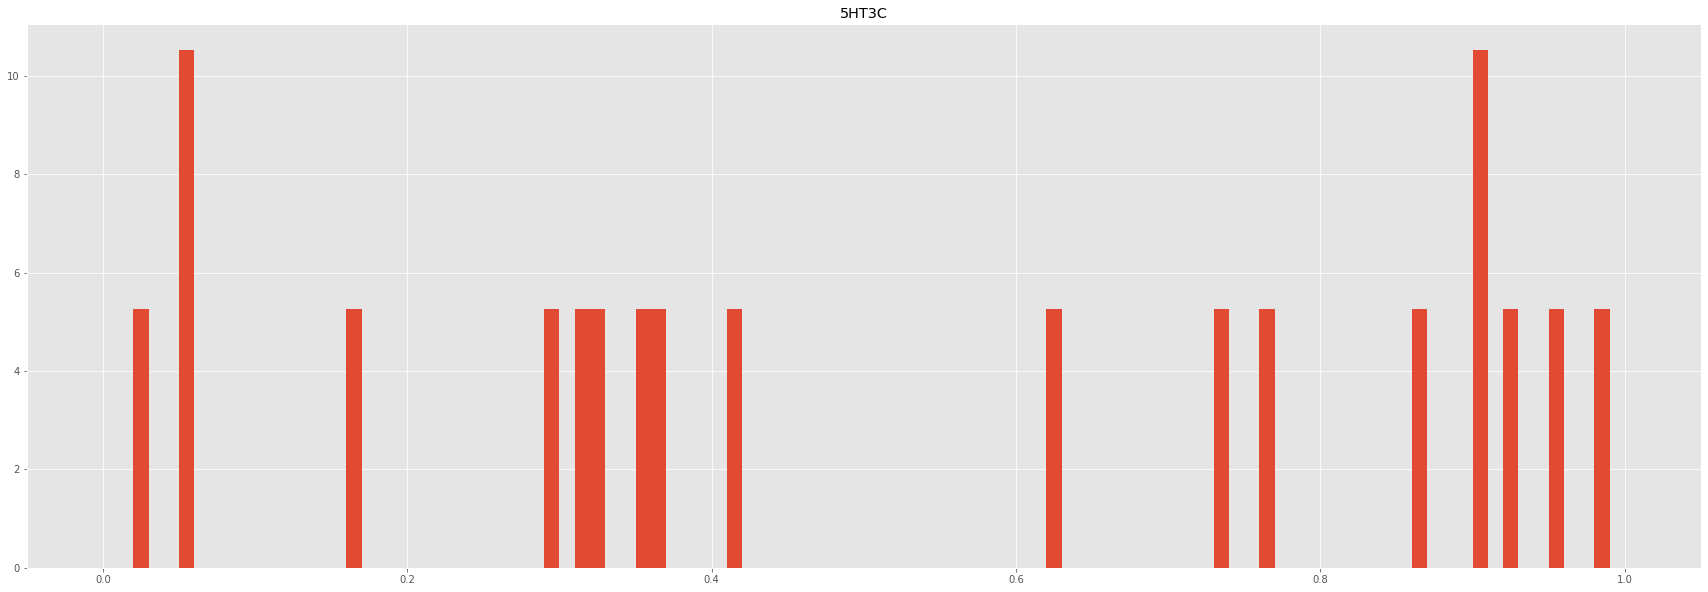

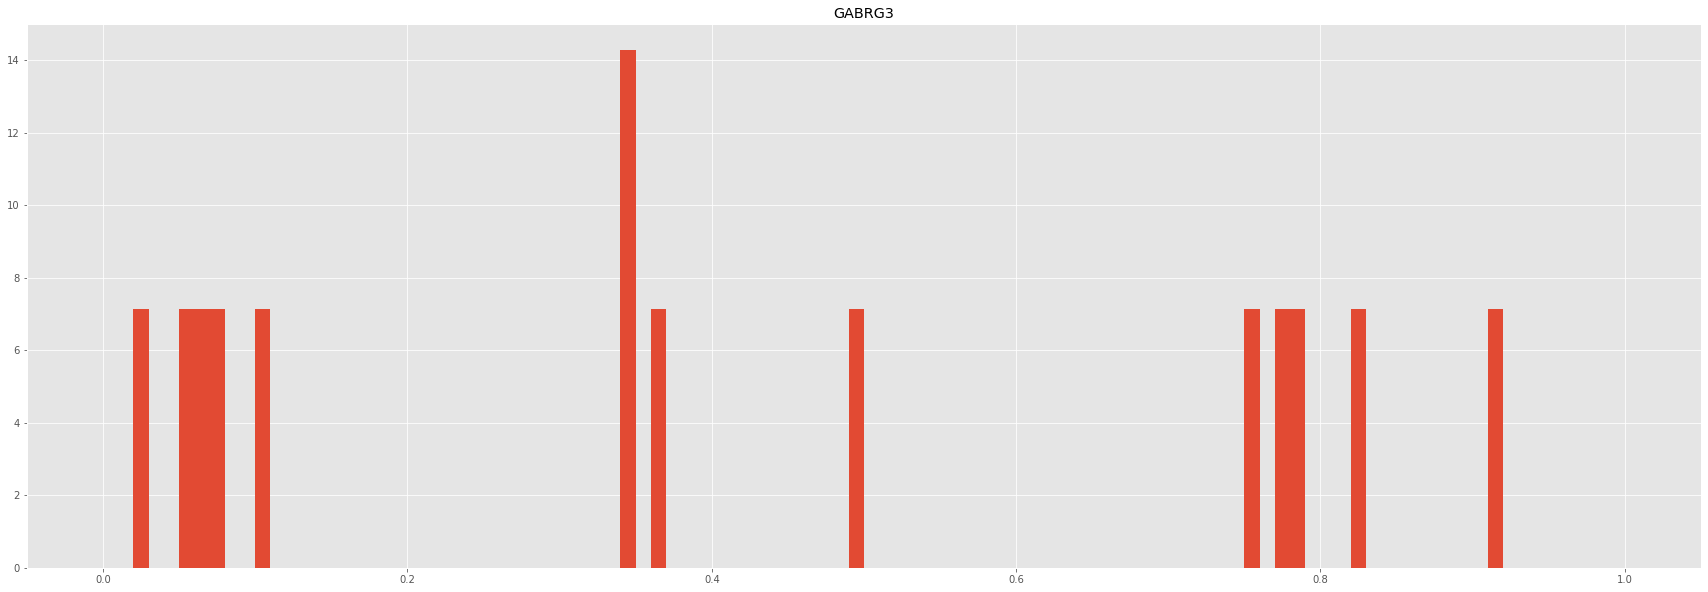

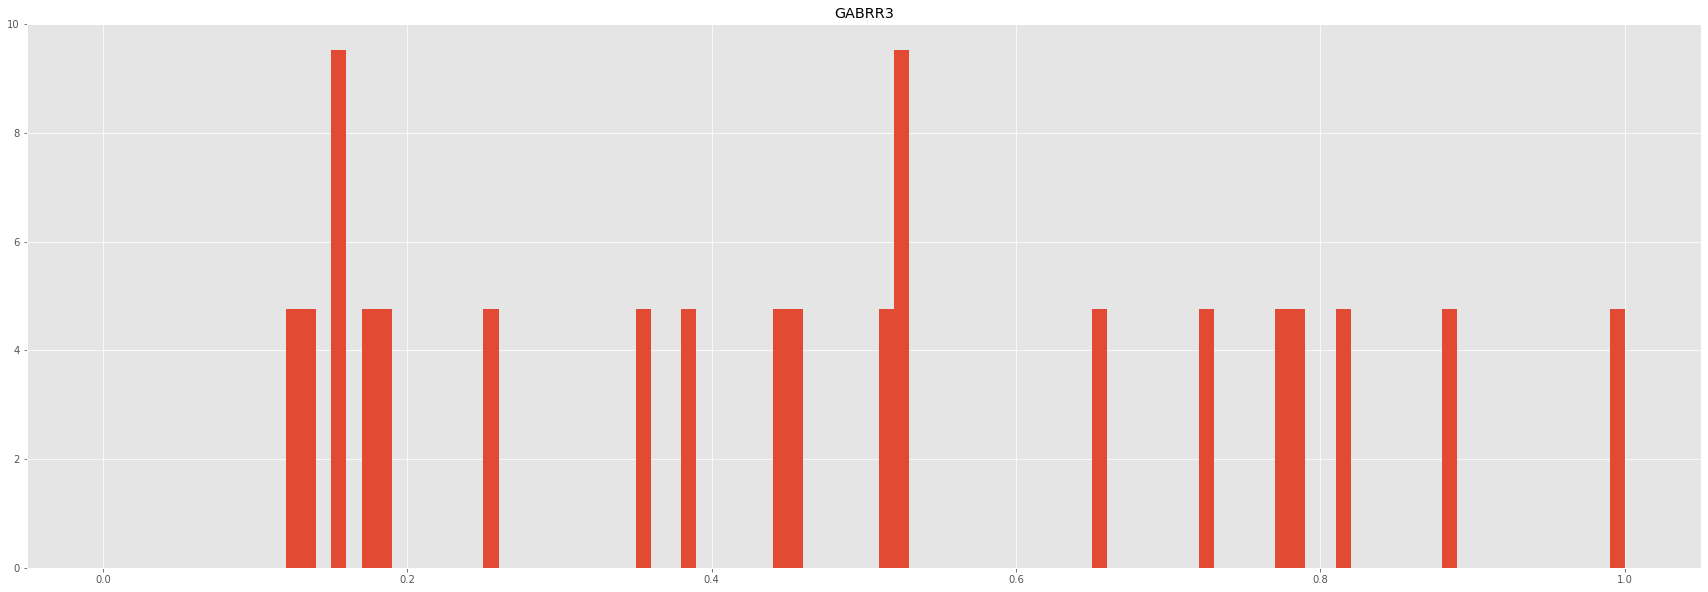

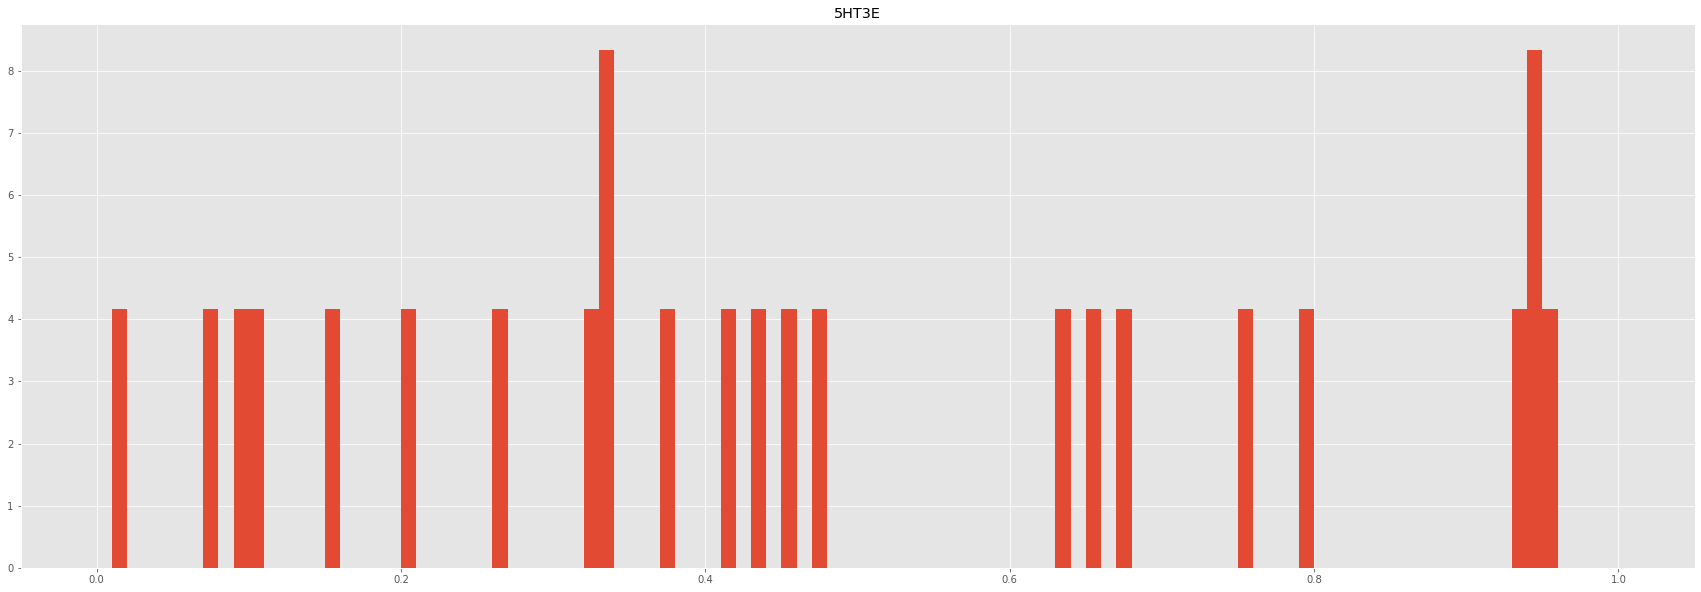

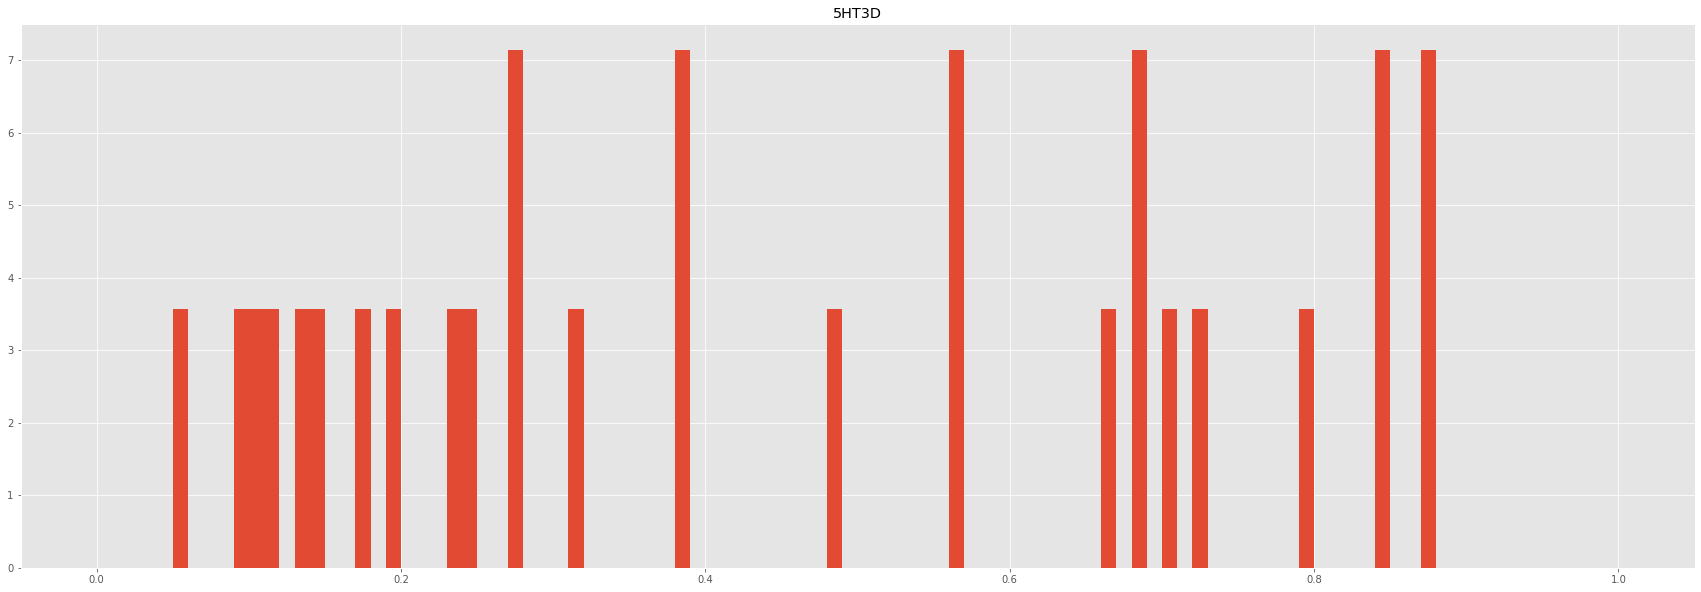

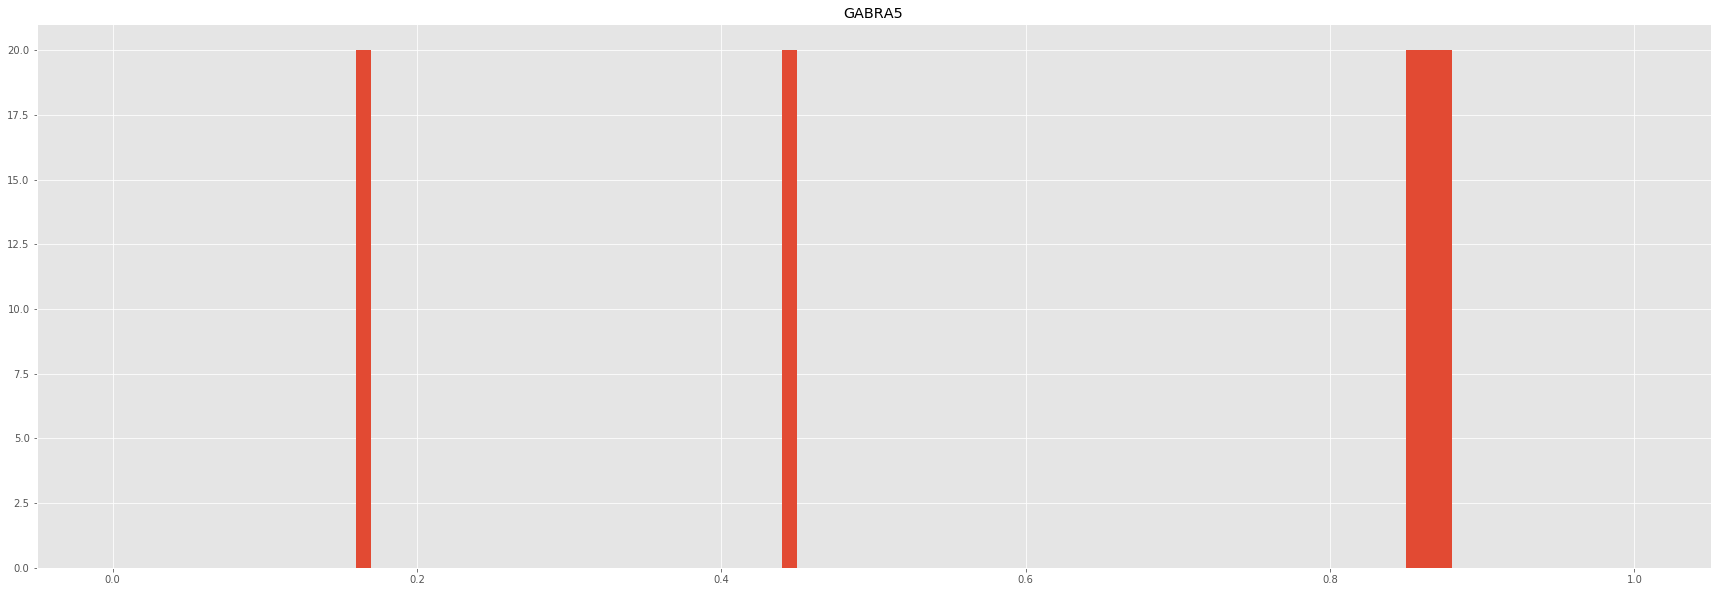

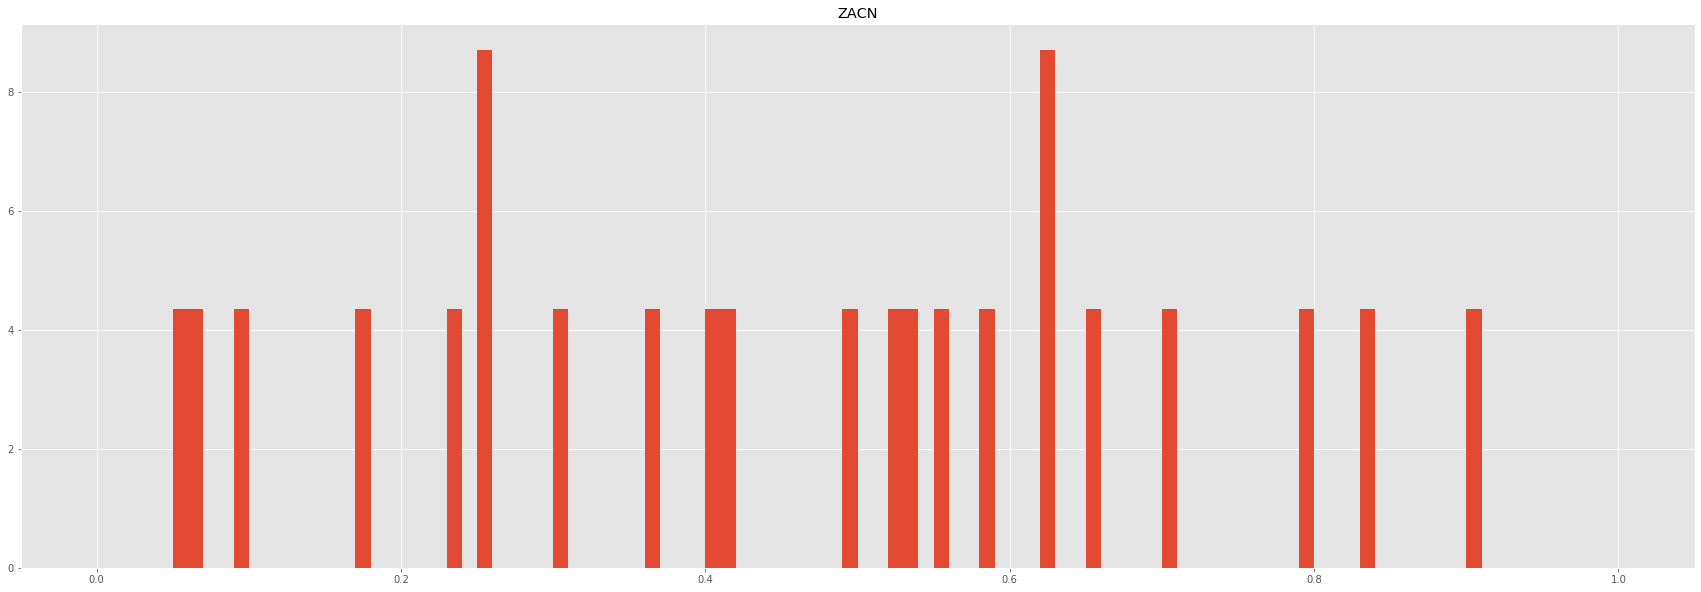

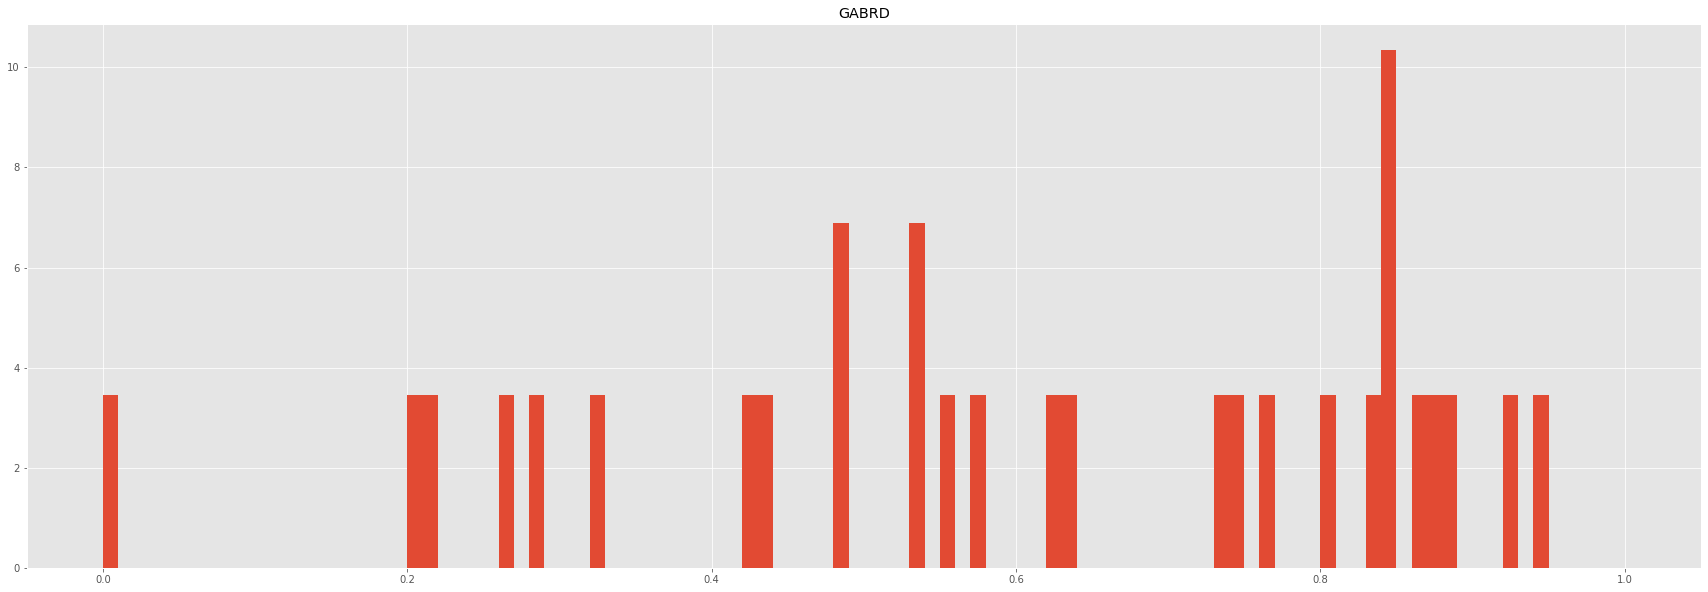

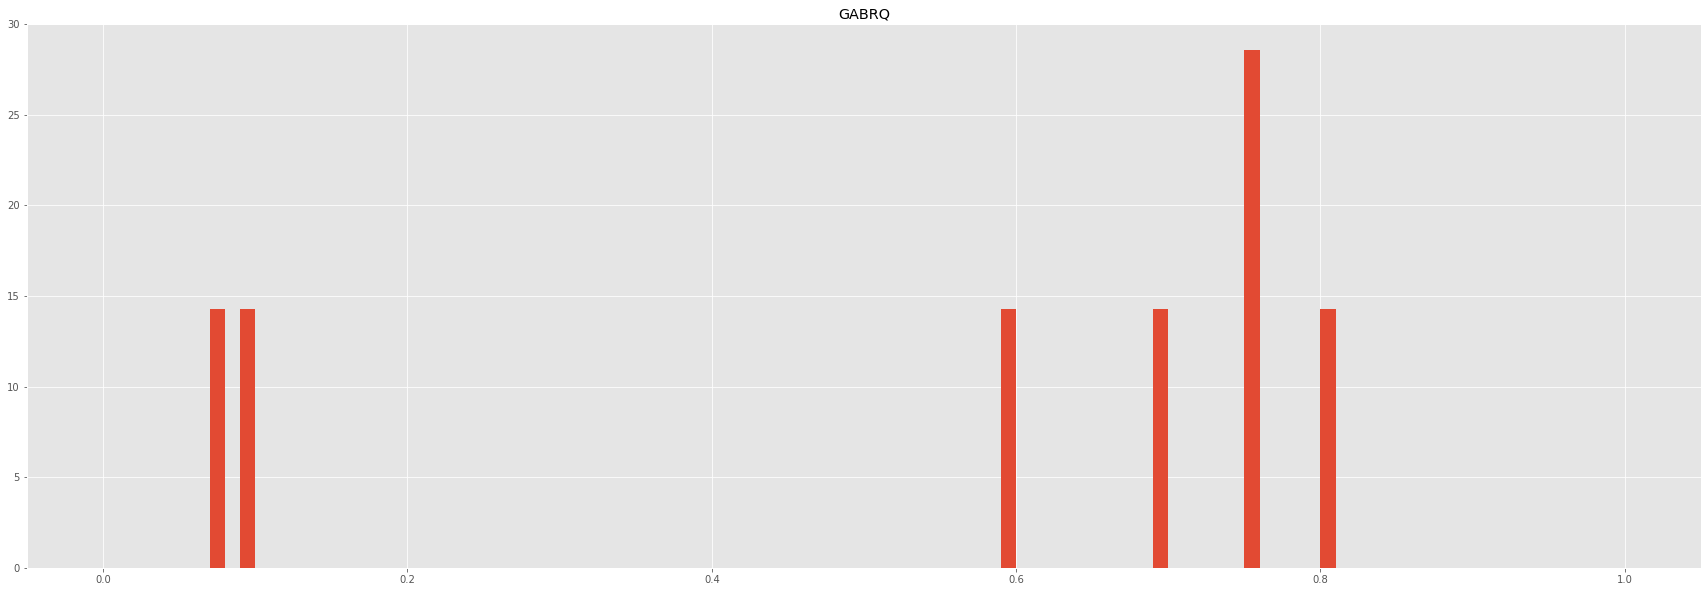

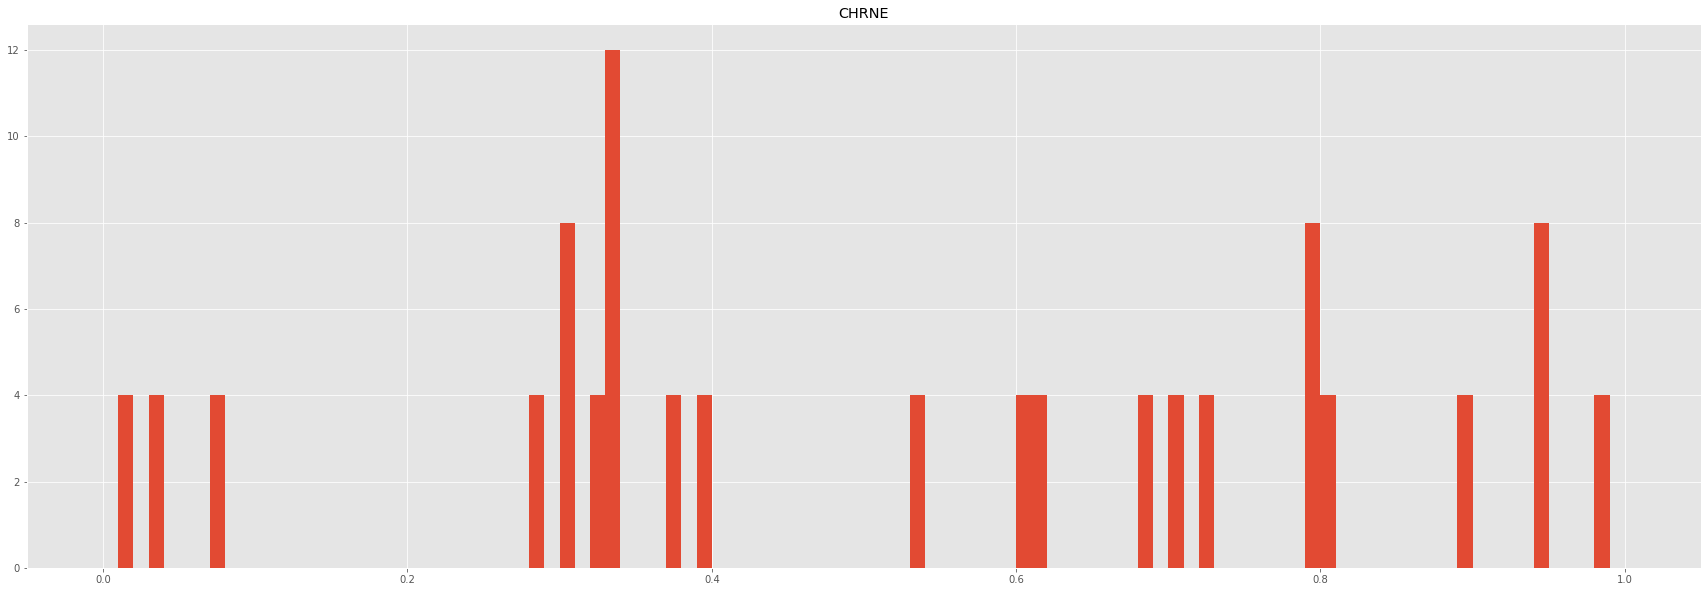

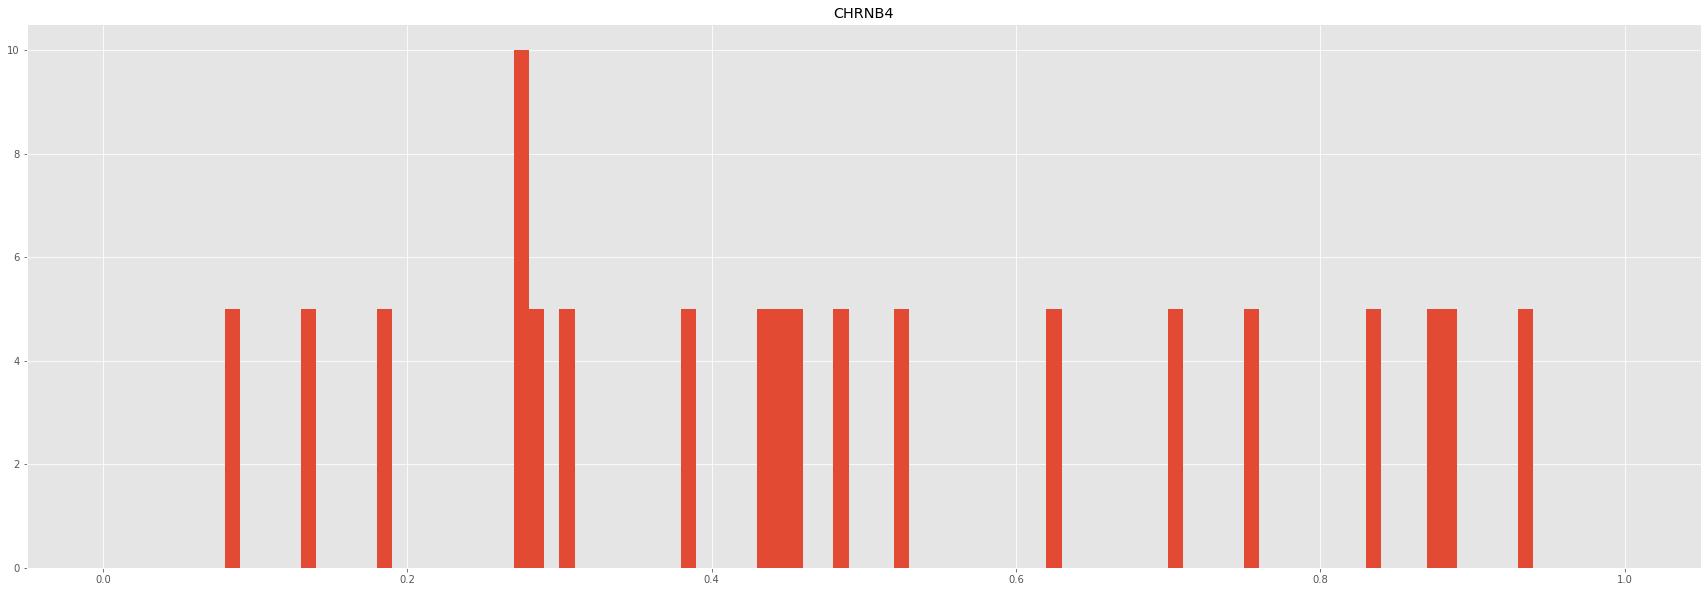

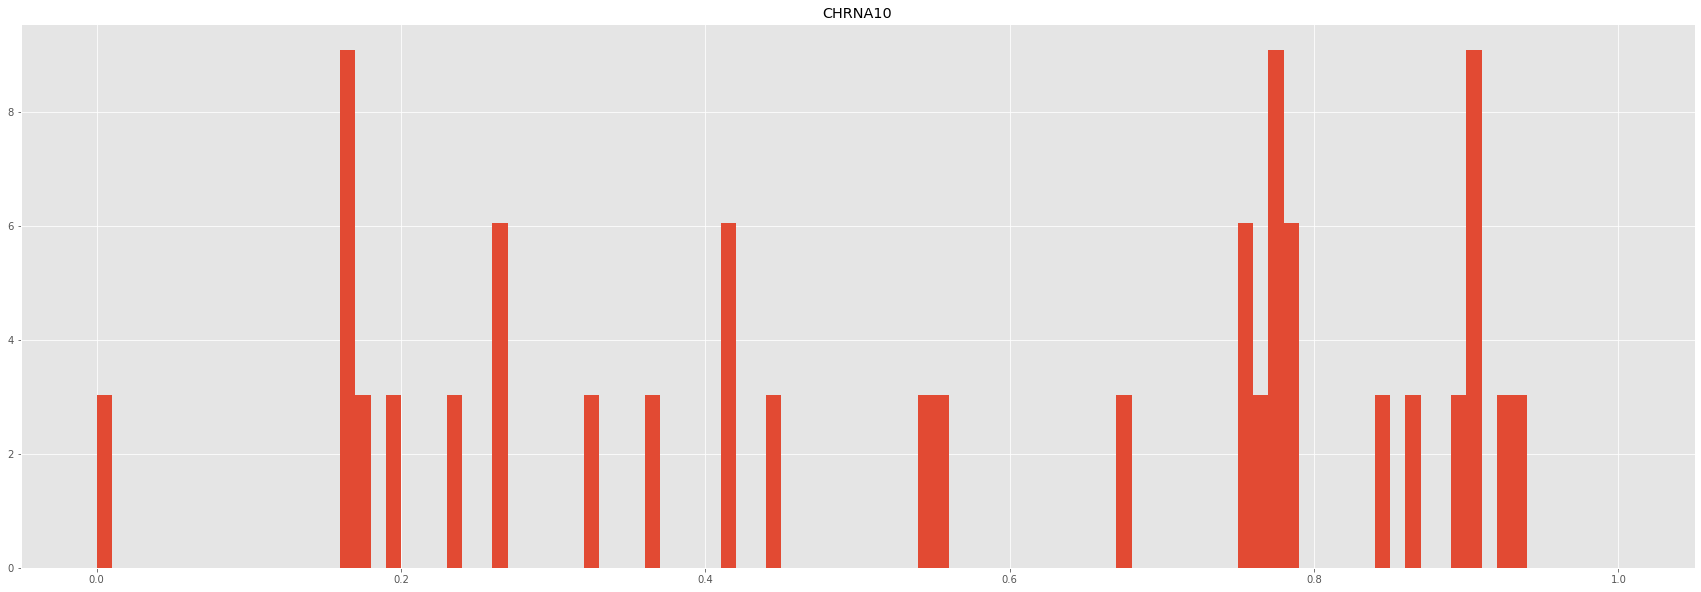

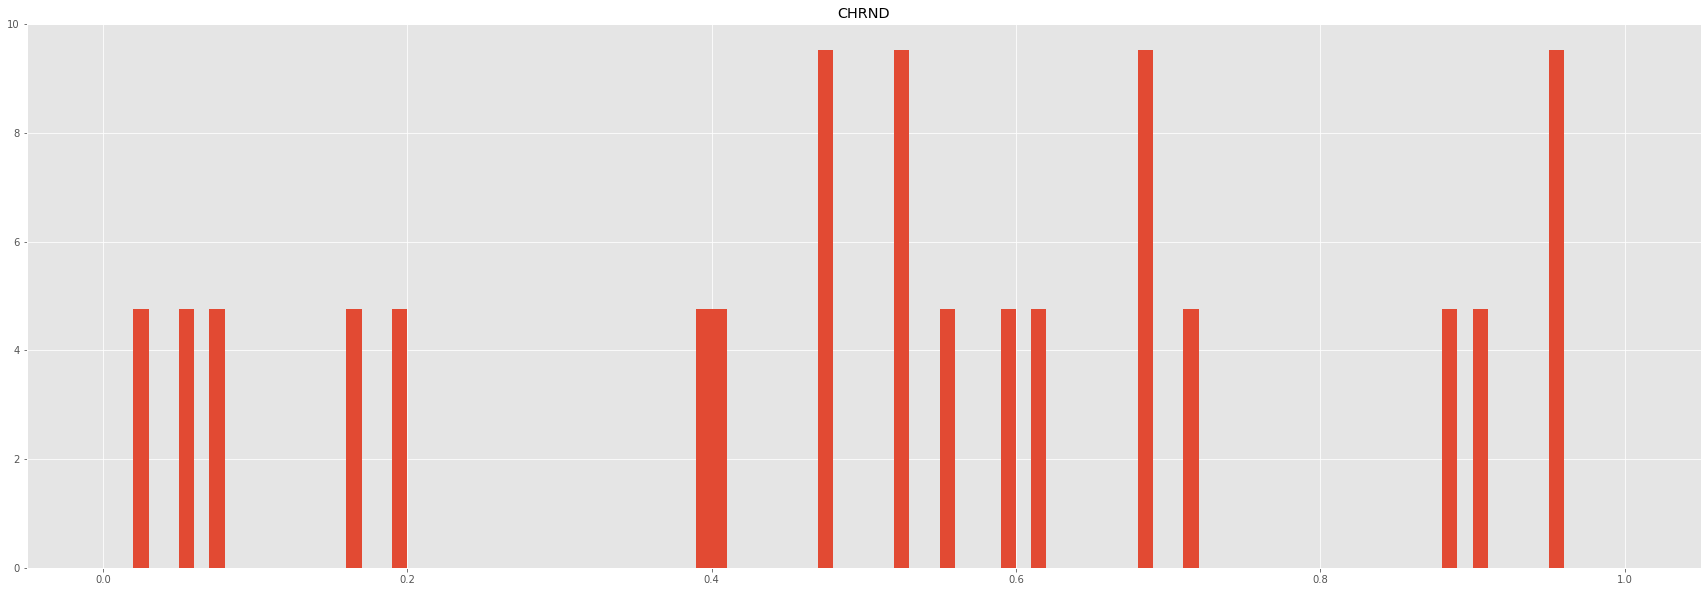

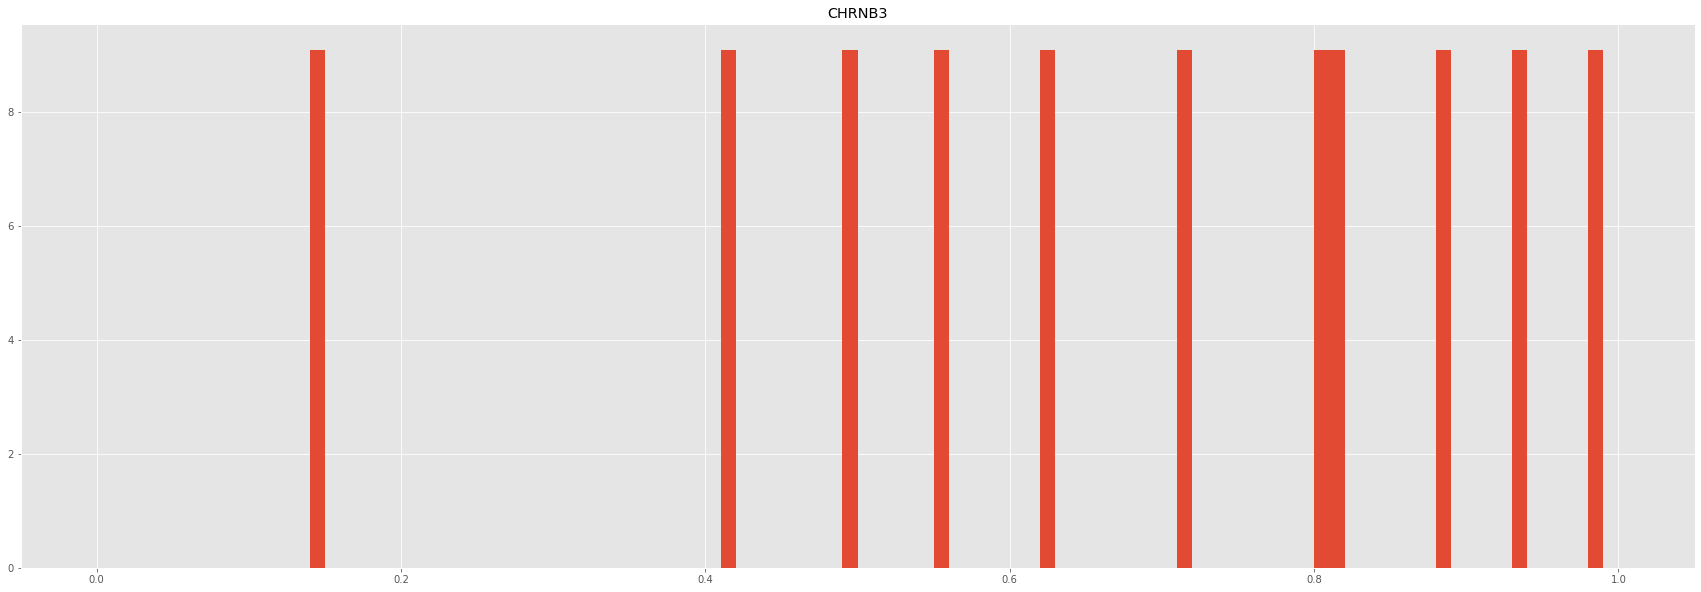

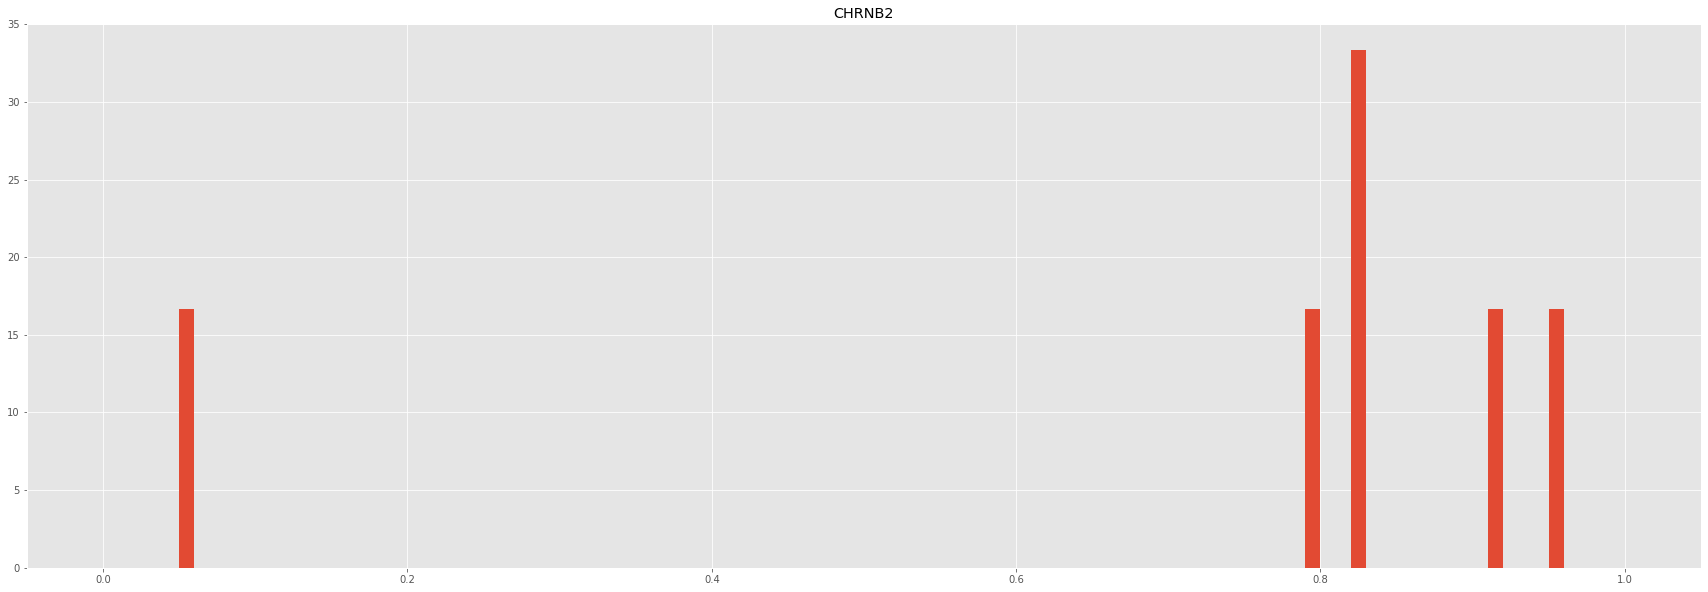

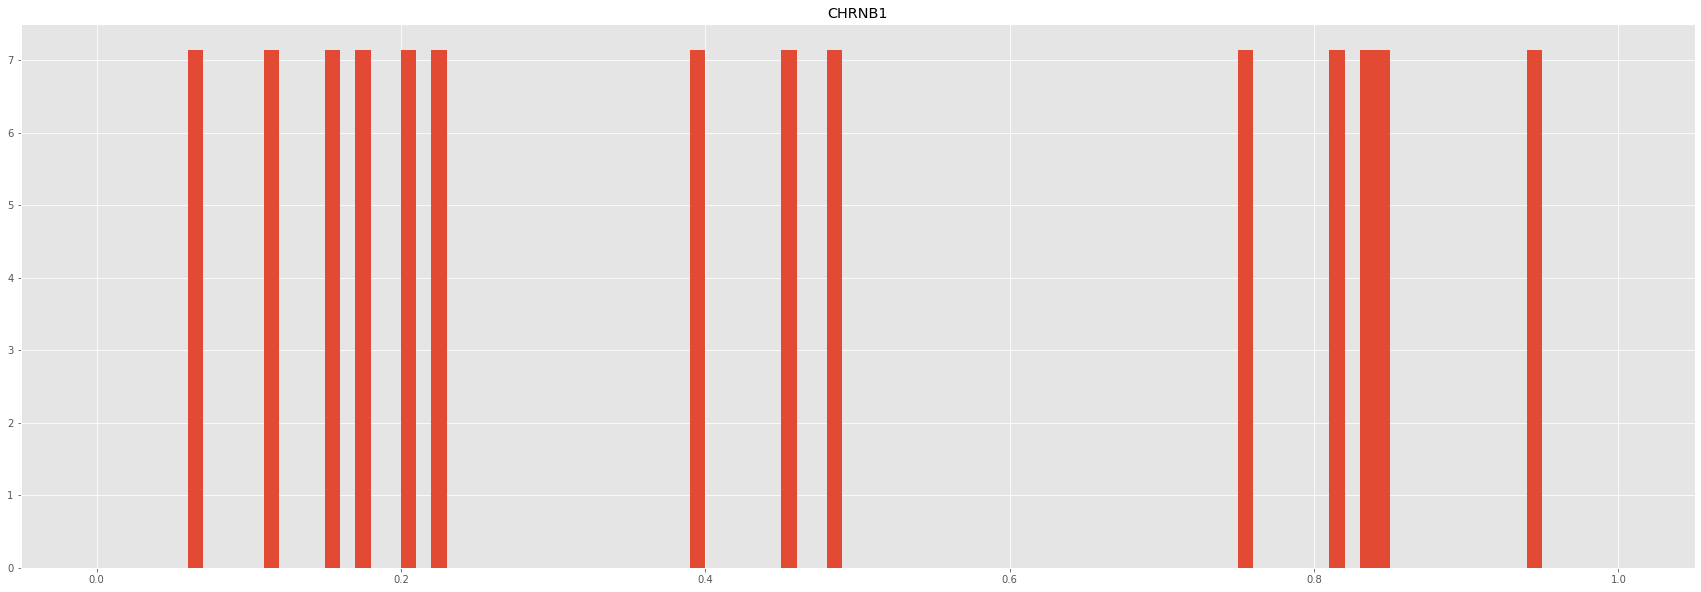

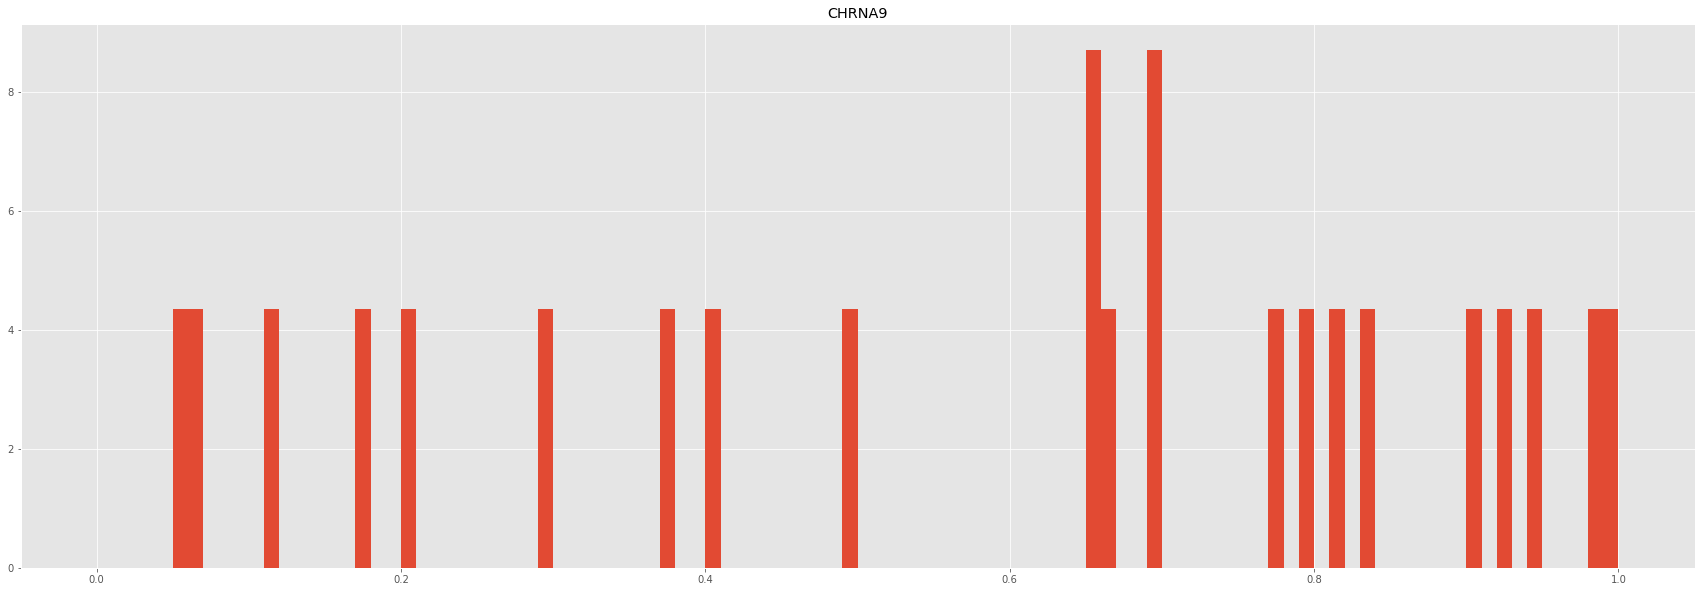

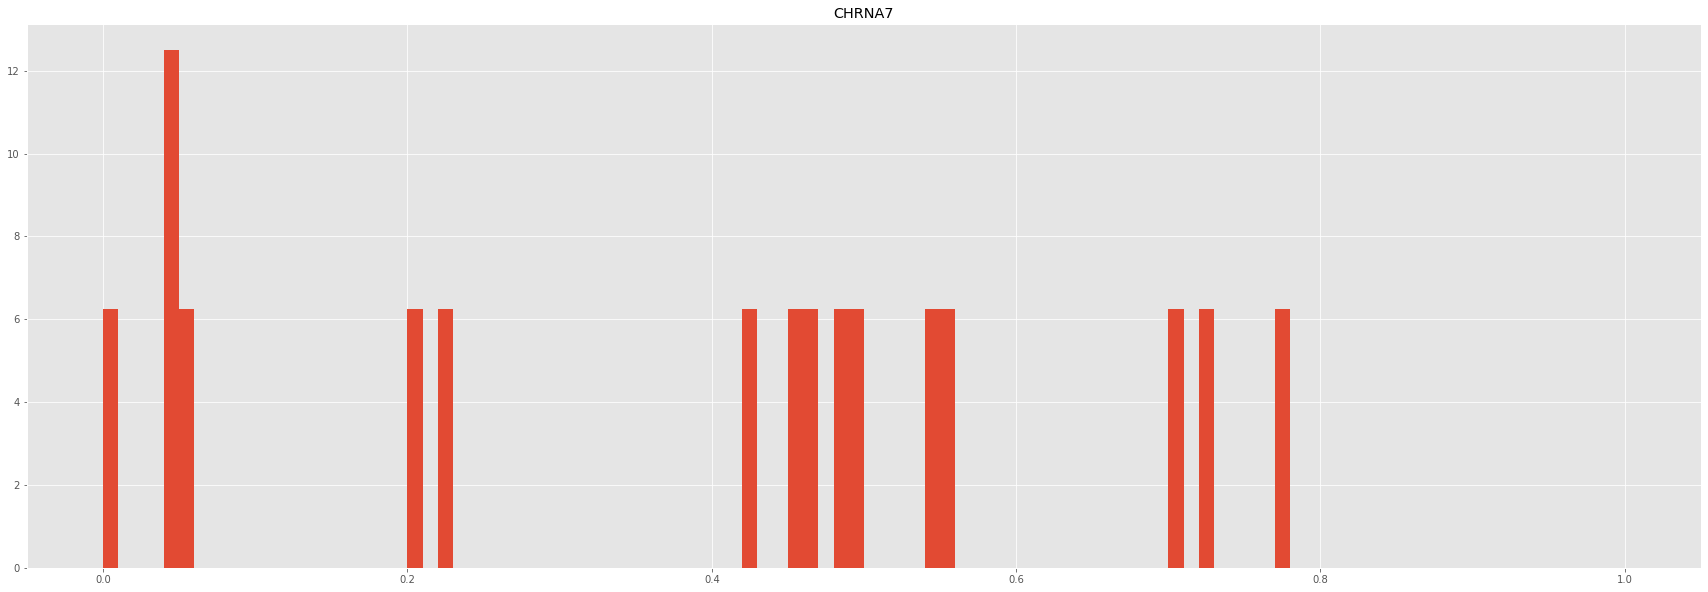

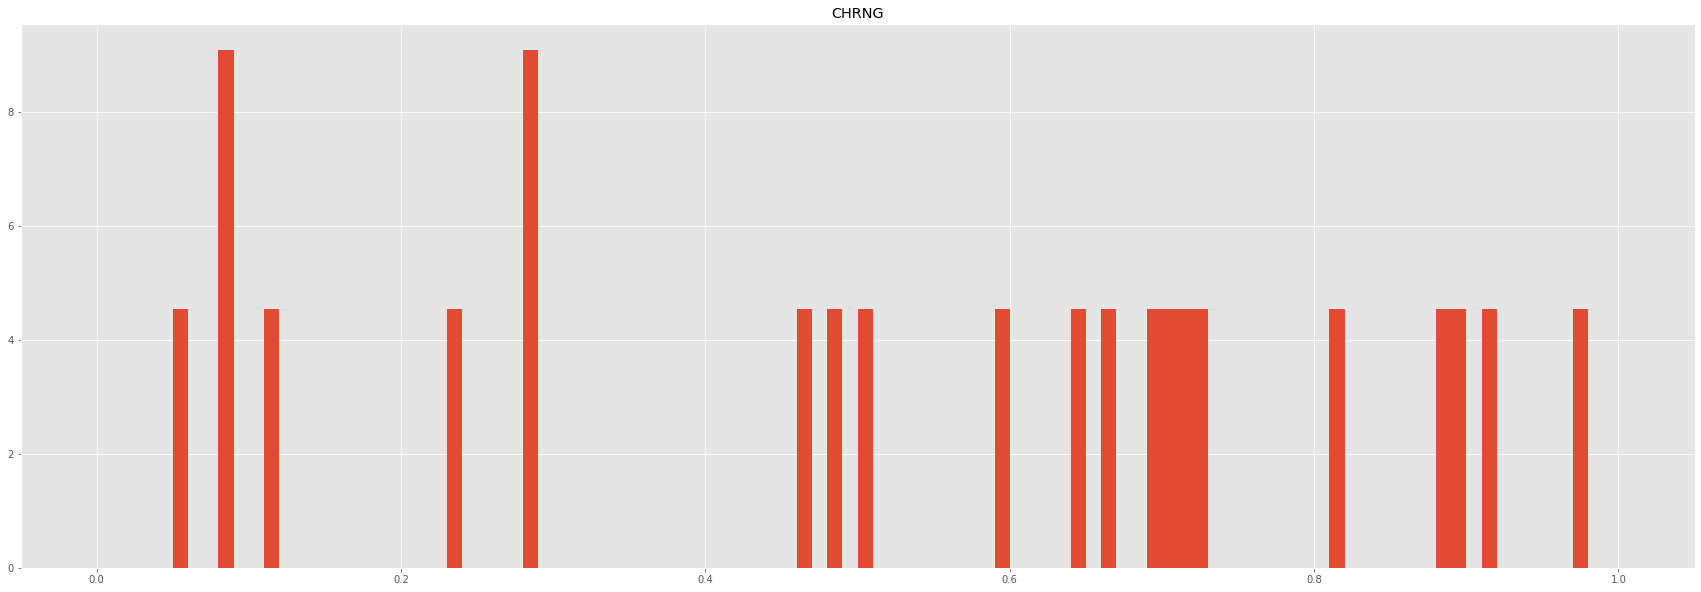

In [92]:
for gene in missense["Gene"].unique():
    pyplot.hist(missense["AA Relative"][missense["Gene"] == gene], bins=[x*0.01 for x in range(0, 101)], density=True)
    pyplot.title(gene)
    pyplot.show()

## Starting the alignment work

### Producing the alignment
The alignment was produced through predicted structures by AlphaFold. The sequences used in the prediction are human reference sequences from UniProt, so the predicted structures should be complete. After fetching all the structures, these were imported into MOE session, where they were aligned. First, a global `optimized for superposition` alignment was performed. After that, sequence before the start of the first beta sheet and the domain between M3 and M4 were separately aligned with `sequence only alignment` option. These parts of structures are highly mobile, but are also less important for the comparison. As such, a sequence-based alignment is good enough.

### Using the alignment

In [93]:
from Bio import AlignIO
from Bio.Seq import Seq

In [94]:
alignment = AlignIO.read("Alignment.aln", "clustal")

In [95]:
print(alignment)

Alignment with 45 rows and 766 columns
-------------------------------MRKSPGLSDCLWA...--- GABRA1
-------------------------------MKTKLNIYNMQFL...--- GABRA2
------MIITQTSHCYMTSLGILFLINILPGTTGQGESRRQEPG...--- GABRA3
-------------------------MVSAKKVPAIALSAGVSFA...--- GABRA4
------------------------MDNGMFSGFIMIKNLLLFCI...--- GABRA5
-----------------------------------------MAS...--- GABRA6
------------------------------------MWTVQNRE...--- GABRB1
-------------------------------------MWRVRKR...--- GABRB2
------------------------------------MWGLAGGR...--- GABRB3
---------MGPLKAFLFSPFLLRSQSRGVRLVFLLLTLHLGNC...--- GABRG1
-------MSSPNIWSTGSSVYSTPVFSQKMTVWILLLLSLYPGF...--- GABRG2
--------------------------MAPKLLLLLCLFSGLHAR...--- GABRG3
---------------------------------MDAPARLLAPL...--- GABRD
--MLSKVLPVLLGILLILQSRVEGPQTESKNEASSRDVVYGPQP...--- GABRE
------------------------------------MNYSLHLA...--- GABRP
--------------MGIRGMLRAAVILLLIRTWLAEGNYPSPIP...--- GABRQ
MLAVPNMRFGIFLLWWGWVLATESRMHWPGREVHEMS

In [96]:
from Bio import AlignIO
from Bio.Seq import Seq
from Bio.SeqUtils import seq1

class Alignment:
    def __init__(self, alignment_file) -> None:
        alignment = AlignIO.read(alignment_file, "clustal")
        self._sequences = {sequence.id: sequence for sequence in alignment}
    
    def convert_to_reference(self, id, acid, number):
        """
        Returns the position in the reference sequence (STARTING FROM 1) if found, else -1.
        """
        if len(acid) == 3:
            acid = seq1(acid)
        sequence = self._sequences[id]
        i = 0
        for j, residue in enumerate(sequence):
            if residue != "-":
                i = i+1
                if i == number:
                    if residue == acid:
                        return j+1
                    else:
                        return -1

In [97]:
ali_class = Alignment("Alignment.aln")

In [98]:
ali_class.convert_to_reference("GABRA1", "T", 20) # Test; should be 51

51

In [99]:
missense.iloc[0][["Gene", "Protein Consequence"]]

Gene                       GABRA3
Protein Consequence    p.Ile20Phe
Name: 330, dtype: object

In [106]:
missense["AA Referenced"] = -1
missense.reset_index(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [107]:
e = 0
for i in range(0, missense.shape[0]-1):
    try:
        missense.at[i, "AA Referenced"] = ali_class.convert_to_reference(missense.iloc[i]["Gene"], missense.iloc[i]["Protein Consequence"].split(".")[1][0:3], missense.iloc[i]["AA Number"])
    except AttributeError:
        e = e+1
        print(e)

In [112]:
missense["AA Referenced"] = missense.apply(lambda x: ali_class.convert_to_reference(x["Gene"], x["Protein Consequence"].split(".")[1][0:3], x["AA Number"]), axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [113]:
print(-sum(missense["AA Referenced"][missense["AA Referenced"] == -1]))
print(-sum(missense["AA Referenced"][missense["AA Referenced"] == -1]) / missense.shape[0])

124
0.17893217893217894


In [114]:
for gene in missense["Gene"].unique():
    print(f"{gene}: {-sum(missense['AA Referenced'][(missense['AA Referenced'] == -1)&(missense['Gene'] == gene)])}")

GABRA3: 0
GABRA1: 0
CHRNA3: 1
GABRP: 0
CHRNA4: 0
GLRA2: 0
GABRE: 0
GABRA4: 0
GLRB: 0
GABRR2: 0
GABRG2: 13
CHRNA2: 0
CHRNA1: 26
GLRA3: 0
GABRA6: 2
GABRB2: 0
GLRA1: 5
GABRR1: 0
CHRNA6: 0
5HT3B: 0
GABRA2: 1
GABRG1: 0
GABRB1: 0
GABRB3: 8
5HT3A: 1
CHRNA5: 0
5HT3C: 0
GABRG3: 6
GABRR3: 0
5HT3E: 3
5HT3D: 23
GABRA5: 0
ZACN: 0
GABRD: 17
GABRQ: 1
CHRNE: 4
CHRNB4: 4
CHRNA10: 1
CHRND: 0
CHRNB3: 0
CHRNB2: 0
CHRNB1: 1
CHRNA9: 0
CHRNA7: 7
CHRNG: 0


In [115]:
for gene in missense["Gene"].unique():
    print(f"{gene}: {-sum(missense['AA Referenced'][(missense['AA Referenced'] == -1)&(missense['Gene'] == gene)]) / sum(missense['Gene'] == gene)}")

GABRA3: 0.0
GABRA1: 0.0
CHRNA3: 0.07692307692307693
GABRP: 0.0
CHRNA4: 0.0
GLRA2: 0.0
GABRE: 0.0
GABRA4: 0.0
GLRB: 0.0
GABRR2: 0.0
GABRG2: 0.9285714285714286
CHRNA2: 0.0
CHRNA1: 0.8125
GLRA3: 0.0
GABRA6: 0.13333333333333333
GABRB2: 0.0
GLRA1: 0.5555555555555556
GABRR1: 0.0
CHRNA6: 0.0
5HT3B: 0.0
GABRA2: 0.2
GABRG1: 0.0
GABRB1: 0.0
GABRB3: 0.8888888888888888
5HT3A: 0.05
CHRNA5: 0.0
5HT3C: 0.0
GABRG3: 0.42857142857142855
GABRR3: 0.0
5HT3E: 0.125
5HT3D: 0.8214285714285714
GABRA5: 0.0
ZACN: 0.0
GABRD: 0.5862068965517241
GABRQ: 0.14285714285714285
CHRNE: 0.16
CHRNB4: 0.2
CHRNA10: 0.030303030303030304
CHRND: 0.0
CHRNB3: 0.0
CHRNB2: 0.0
CHRNB1: 0.07142857142857142
CHRNA9: 0.0
CHRNA7: 0.4375
CHRNG: 0.0


Apparently if we leave this problem be, we will loose some of the genes. Let's check on 5-HT3D if we can solve the problem with accounting for the signal peptide.

In [117]:
signal_len = 0
subsample = missense[missense["Gene"] == "5HT3D"]
subsample.reset_index()
for i in range(0, subsample.shape[0]):
    print(ali_class.convert_to_reference(subsample.iloc[i]["Gene"], subsample.iloc[i]["Protein Consequence"].split(".")[1][0:3], subsample.iloc[i]["AA Number"]+signal_len))

78
115
-1
126
-1
-1
95
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
441
-1
-1
-1
-1
-1
-1


In [125]:
_numbers_id = []
for signal_len in range(0, 40):
    subsample["AA Referenced"] = subsample.apply(lambda x: ali_class.convert_to_reference(x["Gene"], x["Protein Consequence"].split(".")[1][0:3], x["AA Number"]+signal_len), axis=1)
    _numbers_id.append(sum(subsample["AA Referenced"] != -1))
print(subsample.shape[0])
print(_numbers_id)

28
[5, 0, 3, 2, 2, 1, 0, 0, 1, 5, 0, 0, 0, 1, 1, 4, 2, 1, 2, 2, 1, 3, 2, 1, 1, 5, 2, 4, 2, 1, 1, 1, 0, 1, 1, 1, 3, 1, 0, 1]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [123]:
print(subsample.iloc[2]["Protein Consequence"])
print(seq1("Gln"))

p.Gln27Glu
Q


We have for now 17 % of SNPs where the numbering of amino acid was incorrect. We might reduce this by accounting for the signal peptide and ultimately through manual search. Is this worth it though?

For now we check where we find the variants in the reference sequence.

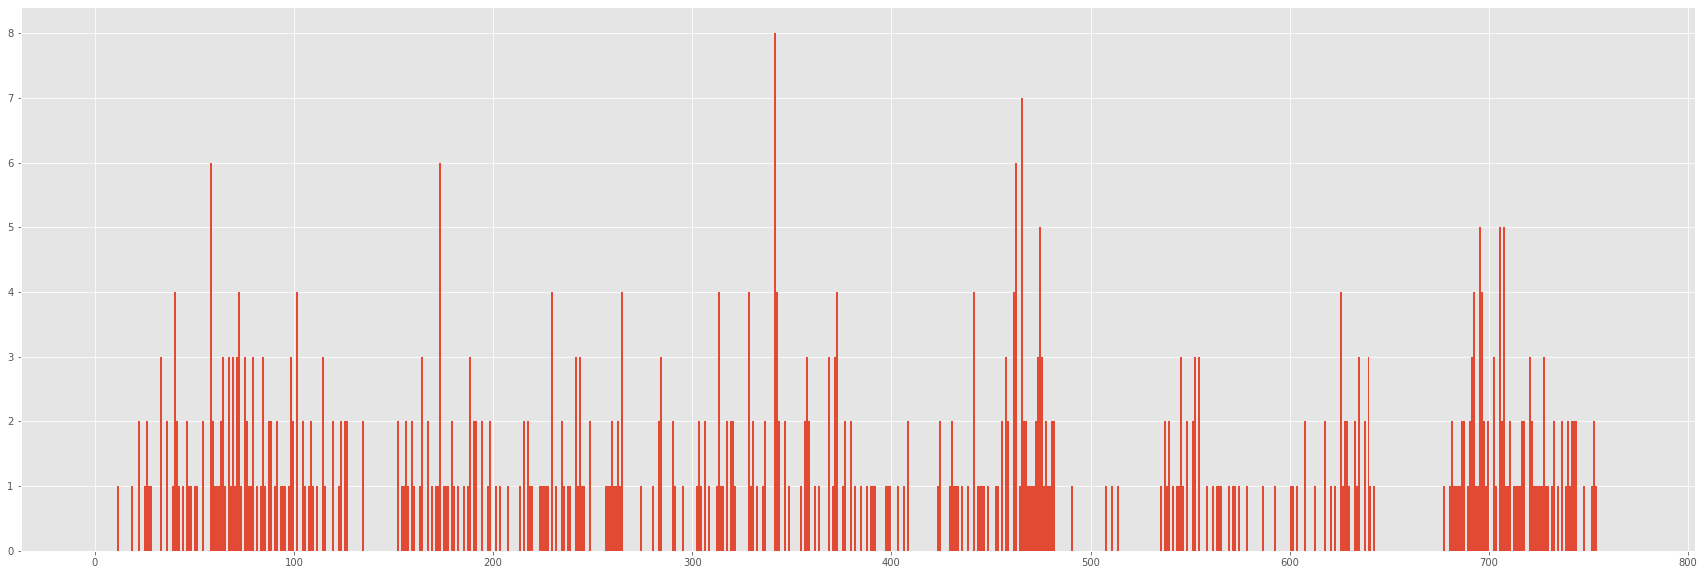

In [38]:
found_missense = missense[missense["AA Referenced"] != -1]
pyplot.hist(found_missense["AA Referenced"], bins=[x for x in range(1, len(alignment[0]))])
pyplot.show()